# Tides
As a prelude to developing a tide clock I wanted to explore the IoT access to tide data from Ocean.org and [noaa.gov](https://tidesandcurrents.noaa.gov/noaatidepredictions.html?id=8518490) sites

*n.b. some of this work started in CoLab so the code sections may contain the `#@commands` unique to that implementation of Jupyter*

### Libraries

In [2]:
# Non CoLab we want to see the graphs inline (not notebook which makes it interactive)
%matplotlib inline

#@title Basic Libraries
#@markdown data handling and graphics
import pandas as pd
# First the usual imports:
import numpy as np
# matplotlib is the tool that will create the graphs
import matplotlib.pyplot as plt

#@markdown Time libraries
from datetime import tzinfo, timedelta, datetime, date
from pytz import timezone  # should already be part of pandas but it doesn't hurt to do it again.
EST = timezone('America/New_York')

import time
# quick test of 'aware' time
datetime.now(tz=EST).isoformat()

'2025-02-10T09:12:26.081084-05:00'

### Common Elements 

In [ ]:
# With each call we flip the units so we toggle back and
# forth between metric and imperial (we have an international audience)
gTideUnit = 'Tide [ft]' # 'Tide [m]'  # Default units
# values for REST call
measure = ("english", "metric")

stationsNearUs = {  'NewRochelleNY':  "8518490",
                    'RyePlaylandNY':  "8518091",
                    'CosCobCT':       "8469549",
                    'ThrogsNeckBrNY': "8518526",
                    'KingsPointNY':   "8516945",
                    'BatteryNY':      "8518750",
                    'BridgeportCT':   "8467150",
                    'NewHavenCT':     "8465705",
                    "NewboldPA":      "8548989",  # Way up the Chesapeake River
                    'TurkeyPointNY':  "8518962",  # Way up the Hudson River
                    }

tideStation = stationsNearUs['RyePlaylandNY']  # Closest one to us with reliable data
# Visual check at [Mamaroneck Web Cam](https://www.weatherbug.com/weather-camera/?cam=MMBPC) for checking the tides?


## Working Code

### library routines in `tidedata.py`

In [ ]:
###
# fetchTideData
# Get raw data from the NOAA tide database/calculator. Tide information is generated based on a harmonic analysis of
# many years of data. The parameters change every 20 years or so so I could just fetch the numbers but NOAA is cagey
# about how to input the time (what epoch constitutes 0 for example) So I pull the data based on our location.  What
# I do to spare the server is to cache the result so I only pull the data once per day.  This way my 'tide' clock can
# update the current pointer once per 5 minutes without hammering on the server.  This is just the inet fetch part.
#
def fetchTideData(station, begDate, endDate, datum="MLLW", interval=15, timezone="LST_LDT", units="english", clock="24hour"):
  """
  fetchTideData
  Fetch tide from NOAA Site using REST -> pandas DataFrame with tide levels
  required arguments:
    station -- StationID
    begDate -- start date (only fetches using day)
    endDate -- end date

    units -- "english" | "metric" # units
    interval -- "hilo" | "h" | 30 | 15 | 6 | 1 # hi and lo, hourly, min intervals
    datum -- "MLLW" | "STND" | "MHHW" | "MHW" | "MTL" | "MLW" | "MLLW" | "NAVD" # height references
    tzone -- "LST_LDT" | "LST" | "GMT" # Local with dst, local or GMT
    clock -- "24hour" | "12hour" # clock style

    This routine checks a local cache cache so that we don't have to fetch that doesn't change
    that much over a 24 hour period.

  """
  noaaSite = [f"https://tidesandcurrents.noaa.gov/api/datagetter?product=predictions&application=NOS.COOPS.TAC.WL",
              f"&begin_date={begDate.strftime('%Y%m%d')}&end_date={endDate.strftime('%Y%m%d')}",
              f"&datum={datum}",
              f"&station={station}",
              f"&time_zone={timezone}&clock={clock}",
              f"&units={units}&interval={interval}&format=csv",
              ]

  # return "".join(noaaSite)
  tideDF = pd.read_csv("".join(noaaSite))

  # First we need to rename some of the columns to take out extraneous spaces
  repl = dict([(s, s.strip()) for s in tideDF.columns])
  tideDF = tideDF.rename(repl, axis='columns')

  # convert string dates to proper date times and other conveniences for future expansion
  #TODO: Consider only fetching GMT but passing tz object as local timezone
  tideDF['DateTime'] = tideDF['Date Time'].apply(lambda x:datetime.strptime(x, "%Y-%m-%d %H:%M").replace(tzinfo=EST))

  # Provide a column with delta hours for calculations (used mostly for debugging)
  minTime = tideDF['DateTime'].min()
  tideDF['Hours'] = tideDF['DateTime'].apply(lambda x:(x-minTime).total_seconds()/3600)

  # Break out the date and time as a strings for comparison tricks
  tideDF['Date'] = tideDF['Date Time'].apply(lambda x: x[:10])
  tideDF['Time'] = tideDF['Date Time'].apply(lambda x: x[11:])

  # Regardless of which units we fetched generate a column of the other so we don't need to duplicate calls.
  #TODO: Consider only getting metric and provide column of imperial as an option.
  if units=='english':
    # add the other units to the list
    tideDF = tideDF.rename({'Prediction': 'Tide [ft]'}, axis='columns')
    tideDF['Tide [m]'] = tideDF['Tide [ft]'] / 3.28084
    tideDF['Units'] = 'ft Feet'
  else:
    tideDF = tideDF.rename({'Prediction': 'Tide [m]'}, axis='columns')
    tideDF['Tide [ft]'] = tideDF['Tide [m]'] * 3.28084
    tideDF['Units'] = 'm  Meters'

  return tideDF

In [ ]:
###
# fetchDailyTides
# The entry point for the getting of regular pieces of information about tides.  This routine checks the local
# store and if it is under 24 hours old uses the local cache. Otherwise it refreshes the cache.
#
def fetchDailyTides(fromTideStation):
    """
    fetchDailyTides
    Fetch daily tide predictions to get the tide data for a few days ahead -> (detailDF, extremaDF)
    This method checks for the existance and timelyness of a local store before going to the web.
    before fethcing from the NOAA site.
    fromTideStation -- NOAA tide station code
    """
    # Local store
    detailTidesFile = 'resources/tmp/DetailTides.zip'  # 15 minute intervals (for smooth graph)
    extremTidesFile = 'resources/tmp/ExtremTides.zip'  # Just the hi and low values for extrema

    # Fetch this data once per day.  And run all the subsequent graphics from the local store.
    now       = datetime.now(tz=EST)
    today     = now.date()

    # Proper way to set up timeshifts.
    yesterday = now - timedelta(days=0)
    tomorrow  = now + timedelta(days=2)

    # First look for existing data, if not found: create, if found: load and test for age
    try:
        print("\t...try to read saved data")
        tideDetailDF = pd.read_pickle(detailTidesFile, compression='infer')
        tideExtremDF = pd.read_pickle(extremTidesFile, compression='infer')
    except FileNotFoundError:
        print("\t...file doesn't exist, creating")
        # Get the data
        tideDetailDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date())
        tideDetailDF.to_pickle(detailTidesFile, compression='infer')
        tideExtremDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date(), interval='hilo')
        tideExtremDF.to_pickle(extremTidesFile, compression='infer')

    # Check to see if the data is stale (older than one day)...
    if tideDetailDF['DateTime'][1].date()!=today:
        tideDetailDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date())
        tideDetailDF.to_pickle(detailTidesFile, compression='infer')

    # Check to see if the data is stale (older than one day)...
    if tideExtremDF['DateTime'][1].date()!=today:
        tideExtremDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date(), interval='hilo')
        tideExtremDF.to_pickle(extremTidesFile, compression='infer')

    # The REST Call always returns at least 3 days of infomraiont (can't just return the next 24 hours)
    # so we have to truncate the list.
    selDet = tideDetailDF['DateTime']<tomorrow
    selExt = tideExtremDF['DateTime']<tomorrow

    tideDetailDF = tideDetailDF[selDet]
    tideExtremDF = tideExtremDF[selExt]
    print(f"\t...start: {tideDetailDF['DateTime'].iloc[0]} end:{tideDetailDF['DateTime'].iloc[-1]}")

    return (tideDetailDF, tideExtremDF)

### Graph Routines in `TidesGraph.py`

In [7]:
###
# makeTideGraph
# The business end that makes the fancy graphic that includes a moing line that shows out current time
# against a graph of the tide height.
#
def makeTideGraph(detailDF, extremaDF):
    """
    makeTideGraph
    Make tide ala NOAA from two sets of pandas DataFrames:
    detailDF -- Detailed predicted water levels for complete graph
    extremeDF -- The extrema (highs and lows)
    """
    global gTideUnit # unit switch flag

    graphFile = "resources/tmp/tideGraph.png"

    import matplotlib.transforms
    import matplotlib.dates as mdates

    today = datetime.now(tz=EST).date()

    # Set up the plot and plot the data
    # px = 1/plt.rcParams['figure.dpi']  # pixel in inches (doesn't work if bbox is 'tight')
    fig, ax = plt.subplots(figsize=(11.5, 4))
    # fig, ax = plt.subplots(figsize=(13, 5))

    ax.plot(detailDF['DateTime'], detailDF[gTideUnit], color="blue", alpha=0.8)

    # Markers at extrema with square marks
    ax.scatter(extremaDF['DateTime'], extremaDF[gTideUnit], color="blue", marker="s")
    for index, row in extremaDF.iterrows():
        xy = (row['DateTime'], row[gTideUnit])
        u = gTideUnit.split("[")[1].split("]")[0]   # row['Units']
        ax.annotate(f'{xy[1]:5.1f} {u[:2]}', xy=xy, xytext=(8,0), textcoords='offset points', color='blue')

    # Set the axis labels
    # ax.set_xlabel("Date and Time", fontsize=14, fontstyle='italic', color='SlateGray')
    ax.set_ylabel(f"Tide Level [{u}]", fontsize=14, fontstyle='italic', color='SlateGray')
    # ~put an alternate axis in meters~ Alternate between meters and feet in 5min intervals

    # Put a vetical bar that marks right now.
    now = datetime.now(tz=EST)
    (ymin, ymax) = ax.get_ylim()
    ax.annotate(f"Current Time   {now.time().strftime('%I:%M %p')}", xy=(now, (ymin+ymax)/2), xytext=(-15,-30), textcoords='offset points', color='green', rotation=90.0, alpha=0.6 )
    ax.vlines(now, ymin=ymin, ymax=ymax, transform=ax.get_xaxis_transform(), colors="green", linewidth=4, alpha=0.7)

    #Fix the time axis
    ax.xaxis.set_major_locator(mdates.DayLocator(tz=EST))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4, tz=EST))

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a, %b %d', tz=EST))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M', tz=EST))

    dx = 0.; dy = -10/72.
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    # Create offset transform by 5 points in x direction
    for label in ax.xaxis.get_majorticklabels():
        label.set(horizontalalignment='center', color="darkred", fontweight='bold')
        label.set_transform(label.get_transform() + offset)

    for label in ax.xaxis.get_minorticklabels():
        label.set(horizontalalignment='center', color="darkred")

    ax.grid(True, which='major', linewidth=2, axis='both', alpha=0.7)
    ax.grid(True, which='minor', linestyle="--", axis='both', alpha = 0.5)

    # Display here.
    # fig.show()
    fig.savefig(graphFile, bbox_inches='tight', transparent=True)
    plt.close(fig)

#### Run above

In [ ]:
# Make the tide graph
# Get the data this method tries to fetch from local store first
(ryePlayDetailDF, ryePlayExtremDF) = fetchDailyTides(tideStation)

# make the pseudo NOAA tide graph
makeTideGraph(ryePlayDetailDF, ryePlayExtremDF)

### Graph Routines in `tidesGraphic.py`

In [10]:
#@markdown Make the fancy image with next tide
pathToResources = "resources/"
gTime = '12'
future = 0

def makeTideGraphic(extremaDF, detailDF=None):
    # make up for image import deprecation
    # import PIL
    # import urllib.request
    """
    Make tide ala NOAA from two sets of pandas DataFrames:
    detailDF -- Detailed predicted water levels for complete graph
    extremeDF -- The extrema (highs and lows)
    """
    global gTime

    lbl = {'H': 'HIGH', 'L': 'LOW'}

    # imageURL = 'https://docs.google.com/drawings/d/e/2PACX-1vRPpyCKk834LQUUwoEWDiopLKIcRscn3AoUPynXzNe6jPRLXWt9TBS90Wwm_MjxVoqezD09hbx_0Sw8/pub?w=225&h=159'
    # imageRef = PIL.Image.open(urllib.request.urlopen(imageURL))
    imageRef = pathToResources + 'TideBackground.png' # fetch locally (way faster on a pi)
    imageOverlay = plt.imread(imageRef)
    (hgt,wdt,cols) = imageOverlay.shape

    plt.figure(figsize=(3, 3))

    implot = plt.imshow(imageOverlay)
    # implot.axes.get_xaxis().set_visible(False)
    # implot.axes.get_yaxis().set_visible(False)

    upcoming = extremaDF[extremaDF['DateTime']>datetime.now(tz=EST)]
    nxtTide = upcoming.iloc[0]

    if gTime == '24':
        plt.text(wdt/2, 40, nxtTide['DateTime'].strftime('%H:%M'), fontsize=26.0, ha='center' )
    else:
        plt.text(wdt/2, 40, nxtTide['DateTime'].strftime('%I:%M %p'), fontsize=26.0, ha='center' )
    plt.text(wdt/2, 80, lbl[nxtTide['Type']], fontweight='heavy', color='blue', fontsize=20.0, ha='center')

    if nxtTide['Type'] == 'H':
        len = -50
    else:
        len = 50
    plt.arrow(wdt/6, 65-len/4, 0, len, width=6., color='cyan',
                length_includes_head=True, alpha=0.6, fill=False, linewidth=2.0)

    print(f"next Tide: '{nxtTide['Type']}' len: '{len}'")

    # Somehwat kludgy since we know the range is between -1 and 10ft
    try:
        current = detailDF[detailDF['DateTime']>datetime.now(tz=EST)]
        nxtTide = current.iloc[future]
    finally:
        level = nxtTide['Tide [ft]']  # don't care since all we do is scale

    # arbitrary scaling so we fit tides in our area range from -1ft to +10ft
    sclDepth = (level + 1.5) / 12.0
    scaledTideHeight = int(hgt*sclDepth)

    print(f"time: {current.iloc[future]['DateTime'].strftime('%I:%M %p')}, hgt: {hgt}, level: {level:6.2f}, scaleDepth: {sclDepth:6.3f}, scaledHeight: {scaledTideHeight:6d}")

    plt.title('Next Tide At...')
    plt.axis('off')
    oceanFloor = 20  # bottom in pixel coordinates
    t = np.linspace(0, wdt-2, 50)
    y = (hgt-oceanFloor) - (scaledTideHeight + 2 * np.cos(t/4)**2)
    plt.fill_between(t, hgt-oceanFloor, y, color='SkyBlue', alpha=0.50)

    plt.show()
    #plt.savefig(pathToResources  + 'tmp/' + 'tideCartoon.png', bbox_inches='tight', transparent=True)
    plt.close()


#### Run Above

In [8]:
(ryePlayDetailDF, ryePlayExtremDF) = fetchDailyTides(tideStation)  # run this once for each cartoon
print(f"Tides - min: {ryePlayDetailDF['Tide [ft]'].min()} - max: {ryePlayDetailDF['Tide [ft]'].max()}")

	...try to read saved data
	...start: 2022-12-21 23:56:00-05:00 end:2022-12-24 16:56:00-05:00
Tides - min: -1.14 - max: 8.969


In [ ]:
# Get the data this method tries to fetch from local store first
gTime = '12'
futureStart = 0
# make the pseudo 'next tide' graphic
for i in range(40):
    future = futureStart + i
    makeTideGraphic(ryePlayExtremDF, ryePlayDetailDF)

### Generation Routine in `TidesTable.py`

In [ ]:
#@markdown Make the summary table for the next four tide extrema
def makeTideTable(extremaDF):
    """
    Make the html table of the next 4 tide extrema
    extremeDF -- The extrema (highs and lows)
    """
    global gTideUnit
    lbl = {'H': 'HIGH', 'L': 'LOW'}

    now = datetime.now(tz=EST)

    tideFile = "tideTable.html"
    templateFile = "_" + tideFile

    # pick the units based on gTideUnit

    sel = extremaDF['DateTime'] > now
    futureTides = extremaDF[sel]

    htmlText = futureTides[:4].to_html(
#                            columns=['DateTime', 'Time', 'Type', gTideUnit],
                            columns=['DateTime', 'Type', gTideUnit],
                            index=False,
                            border=0,
                            formatters={
                                gTideUnit: lambda x:f"{x:6.1f}",
                                'Type': lambda l: lbl[l],
                                'DateTime': lambda dt: dt.strftime("%a %I:%M %p")
                                },
#                            table_id = "tideTable"
                            )

    #open the template file
    with open(templateFile, "r") as templateFile:
        templateHTML = templateFile.readlines()

    # print( ("".join(templateHTML)).replace('<!--Table Place-->', htmlText) )
    # print( htmlText )

    # copy the html table into the text and write out a new file
    with open(tideFile, "w") as htmlFile:
        htmlFile.write( ("".join(templateHTML)).replace('<!--Table Place-->', htmlText) )


#### Run Above

In [10]:
# Get the data this method tries to fetch from local store first
(ryePlayDetailDF, ryePlayExtremDF) = fetchDailyTides(tideStation)

# make the pseudo NOAA tide graph
makeTideTable(ryePlayExtremDF)

	...try to read saved data
	...start: 2022-01-28 23:56:00-05:00 end:2022-01-31 13:41:00-05:00


### Generation Routine in `WindGraph.py`

In [44]:
EST = timezone('America/New_York')
UTC = timezone('UTC')

import matplotlib.transforms
import matplotlib.dates as mdates

# Getting Weather Data from execution rocks (station 44022)  Only needs to run every 15 minutes.
def fetchWindData(source):
  now = datetime.now(tz=EST)

  windDF = pd.read_csv(source, header=[0,1], sep="\\s+", nrows=450, na_values='MM') # Deprecated: delim_whitespace=True,
  print(f"\t...got {len(windDF)} data values")

  windDF['DateTime'] = windDF[['#YY','MM','DD','hh','mm']].apply(lambda dt: datetime(dt[0], dt[1], dt[2], dt[3], dt[4], tzinfo=UTC).astimezone(EST), axis=1)
  windDF['Time'] = windDF['DateTime'].apply(lambda t: t.time())
  windDF['Date'] = windDF['DateTime'].apply(lambda d: d.date())
  windDF['Wdir'] = windDF['WDIR'] + 360.0  # done so averaging over modulo 360.0 works properly

  return windDF #.set_index(windDF['DateTime'] - windDF['DateTime'].min()) # returns a new copy
#  return windDF.set_index('DateTime')

def makeWindGraph(windDF, whereFrom=""):
  imageRef = "resources/tmp/windGraph.png" # fetch locally (way faster on a pi)
  fig, ax = plt.subplots(figsize=(8, 4))

  tme = windDF.index
  wspd = windDF['WSPD'] # windDF['WSPD']
  mxsp = windDF['GST'] # windDF['GST']

  # convert m/s to mph: 0.447, m/s to knot: 0.5144
  ax.plot(tme, wspd/0.5144, 'bo-', alpha=0.8)
  ax.plot(tme, mxsp/0.5144, 'ro-', alpha=0.8)

  # Plot direction arrows
  # convert from compass to theta (use coordinate swap to do the rotation)
  angl = np.radians(windDF['Wdir'])
  yloc = 3.0 * np.ones_like(angl)
  # why would we add 360??? because the average between 10 and 350 is 180
  #       when the correct answer w.r.t. wind direction is 0.0 mod(360.0)
  # An arrow every other step
  ax.quiver(tme[::2], yloc[::2], np.sin(angl[::2]), np.cos(angl[::2]),
            angles='uv', color='DodgerBlue', alpha=0.6, pivot='middle')

  # Set the axis labels
  # ax.set_xlabel("Date and Time", fontsize=10, fontstyle='italic', color='SlateGray')  #obvious don't need it.
  ax.set_ylabel("Wind Speed [knots]", fontsize=12, fontstyle='italic', color='SlateGray')

  #Fix the time axis
  ax.xaxis.set_major_locator(mdates.DayLocator(tz=EST))
  ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4, tz=EST))

  ax.xaxis.set_major_formatter(mdates.DateFormatter('%a, %b %d', tz=EST))
  ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M', tz=EST))

  dx = 0.; dy = -10/72.
  offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
  # Create offset transform by 5 points in x direction
  for label in ax.xaxis.get_majorticklabels():
      label.set(horizontalalignment='center', color="darkred", fontweight='bold')
      label.set_transform(label.get_transform() + offset)

  for label in ax.xaxis.get_minorticklabels():
      label.set(horizontalalignment='center', color="darkred")

  ax.grid(True, which='major', linewidth=2, axis='both', alpha=0.7)
  ax.grid(True, which='minor', linestyle="--", axis='both', alpha = 0.5)
  ax.set_ylim(bottom=0.0)

  # where did this come from?
  plt.text(0.99, 0.96, f"{whereFrom}",
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes, color='gray', alpha=0.6 )

  # fig.show()
  fig.savefig(imageRef, bbox_inches='tight', transparent=True)
  plt.close(fig)

# Exscution Rocks weather buoy
real_EXR_TimeDataFile = "https://www.ndbc.noaa.gov/data/realtime2/44022.txt"  #DEAD
# Kings Point
real_KPH_TimeDataFile = "https://www.ndbc.noaa.gov/data/realtime2/KPTN6.txt"
# Western Long Island Sound
real_WLI_TimeDataFile = "https://www.ndbc.noaa.gov/data/realtime2/44040.txt"  #DEAD


#### Run Above

In [46]:
now = datetime.now().astimezone(EST)
d = timedelta(days = 2)

# try to get execution rocks first, then WestLI, falling back to nearest manned land station
try:
    source = "Execution Rocks"
    print(f"\t...source: {source}")
    theDF = fetchWindData(real_EXR_TimeDataFile)
    smpl = theDF['DateTime'] > (now - d)
    makeWindGraph( theDF[smpl].resample('1H', on='DateTime').mean(), source )
except:
    print("\t... failed")
    # if that fails then try western LI buoy
    try:
        source = "Western LI"
        print(f"\t...source: {source}")
        theDF = fetchWindData(real_WLI_TimeDataFile)
        smpl = theDF['DateTime'] > (now - d)
        makeWindGraph( theDF[smpl].resample('1H', on='DateTime').mean(), source )
    except:
        print("\t... failed")
        # if that fails then settle on Kings Point (never fails)
        source = "Kings Point LI"
        print(f"\t...source: {source}")
        theDF = fetchWindData(real_KPH_TimeDataFile)
        smpl = theDF['DateTime'] > (now - d)
        #makeWindGraph( theDF[smpl].resample('1H', on='DateTime').mean(), source )


	...source: Execution Rocks
	... failed
	...source: Western LI
	... failed
	...source: Kings Point LI
	...got 450 data values


/tmp/ipykernel_27295/3295462361.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  windDF['DateTime'] = windDF[['#YY','MM','DD','hh','mm']].apply(lambda dt: datetime(dt[0], dt[1], dt[2], dt[3], dt[4], tzinfo=UTC).astimezone(EST), axis=1)


### Generation Routine in `Forecast.py`

A few notes about this kludge. NOAA is slowly rolling out an efficient REST system for local forecasts. They have yet to implement the marine forecasts. What we do have are web pages that are nicely laid out that can be harvested for the details we need. Each sector provides a set of forecasts for customized regions within.  We can pick the one we want and extract the daily predictions from there.  These short messages are all we want or need. Further I only need a few days out (about 6 panels.)

In [ ]:
import numpy as np
from html.parser import HTMLParser


"""
MarineHTMLParser
    custom extension of HTMLParser to extract informaion from
    NOAA/NWS Marine Forecasts
"""
class MarineHTMLParser(HTMLParser):
  """
    custom class to parse the marine weather forecast for our area
  """
  # an array of dictionaries
  forecasts = []

  def __init__(self):
    """
      init the parser elements
    """
    super(MarineHTMLParser, self).__init__()
    self.inPreString = False
    self.forecast = dict()

  def handle_starttag(self, tag, attrs):
    """
      handle any starting html tag, we are only looking for the <pre> tags
      we initialize the forecast dictionary and the data counter index
    """
    if tag.lower() == "pre":
      self.inPreString = True
      self.forecast = dict()
      self.count = 0

  def handle_endtag(self, tag):
    """
      handle the closing </pre> tag and add the dict to the array
    """
    if tag.lower() == "pre":
      if self.inPreString:  # obviously
        self.forecasts.append(self.forecast)
        self.inPreString = False

  def handle_data(self, data):
    """
      this is the business end, there are a series of data elements
      (I play the cards I'm dealt) the first is a REGION while the second
      is a SYNOPSIS slug, the third is the OVERVIEW. Subsequent data
      pieces are a sequence of TIME and ADVISORY sequences which seem to
      number around 11.
    """
    if self.inPreString:
      if self.count == 0:
        self.forecast['REGION'] = data.strip()
      elif self.count > 0 and self.count % 2 == 1:
        idx = f"TIME{int((self.count+1)/2):02d}"
        self.forecast[idx] = data.strip()
      else:
        idx = f"ADVISORY{int((self.count)/2):02d}"
        self.forecast[idx] = data.strip().replace('\n',' ')
      self.count += 1


#### Run Above

In [ ]:
"""
We want to run this command peridoically to update the clock. I run it within python
we run the risk of memory leaks so I will run it as a periodic bash shell (we only
have to run once every 2hrs or so)
"""
forecastFile = "forecastGrid.html"
templateFile = "_" + forecastFile

# url of marine forecast in our area
url = "https://www.ndbc.noaa.gov/data/Forecasts/FZUS51.KOKX.html"

# creating HTTP response object from given url
parser = MarineHTMLParser()

import urllib.request
with urllib.request.urlopen(url) as resp:
    parser.feed(resp.read().decode("utf-8"))

"""
The first record is special, it contains general information about the region
"""
# print(parser.forecasts[0]['REGION']) # Off. designation for covered area
# print('-')
# print(parser.forecasts[0]['TIME01']) # Short version of location
# print('-')
# print(parser.forecasts[0]['ADVISORY01']) # Reason for following forecasts
# print('-----------')
# print()

"""
The subsequent records follow the pattern of REGION and a sequence of
Times and Advisories
"""
#    for j in range(len(parser.forecasts)):

designation = (parser.forecasts[6]['REGION']).replace('\n',' ').split('- ')
try:
    specialWarning = designation[2].split("...")[1]
    designation[2] = designation[2].split("...")[0]
except:
    specialWarning = ""

        # Off. designation for covered area
titleArea = f'''
    <p class="where">{designation[1]}</p>
    <p class="when">{designation[2]}</p>
    '''
forecastBox = []
for i in range(np.min([6, len(parser.forecasts)-1]) ):
    # print(parser.forecasts[6][f"TIME{i+1:02d}"]) # Short version of location
    # print('==')
    tmeidx = f"TIME{i+1:02d}"
    advidx = f"ADVISORY{i+1:02d}"
    forecastBox.append(f'''
            <p class="what">{parser.forecasts[6][tmeidx]}</h3>
            <p  class="how">{parser.forecasts[6][advidx]}</p>
        ''')

#open and read the template file
with open(templateFile, "r") as templateFile:
    templateData = templateFile.readlines()

# Title Information
templateData = ("".join(templateData)).replace('<!--Forecast Title-->', titleArea)
# Forecast Boxes
for i in range(len(forecastBox)):
    templateData = templateData.replace(f'<!--Forecast Box_{i}-->', forecastBox[i])

templateData = templateData.replace('<!--Special Warning-->', specialWarning)


# copy the html table into the text and write out a new file
with open(forecastFile, "w") as htmlFile:
    htmlFile.write( templateData )

### Make a Lune `moonPhase.py`

A simple but elegant way to create the shadow across the moon's face. We get the fracillium from the usno server and use that to 
create the 'lune'. Here we experiment with backgrounds and such.

In [ ]:
pathToResources = 'resources/'
##
# make a cartoon of a moon with beta % lit
# param beta is %lit.  -1<0 (waning) to 0 (new moon) to 0<1 (waxing)
##
def makeMoonLune(beta):
  print(f"\tgenerating lune: {beta}")

  t = np.linspace(0.0, 1.0, 100)

  def circFunc(t, r=1):
    return (r * np.sin(np.pi * t), r * np.cos(np.pi * t))

  def ellipFunc(t, b=0.0, r=1.0):
    if b>0:
      dir = -1.0
    else:
      dir = 1.0
    return (dir * 2 * (np.abs(b)-1/2) * r * np.sin(np.pi * t), r * np.cos(np.pi * t)) # was b <- np.cos(np.pi * b)

  plt.figure(figsize=(1, 1))
  plt.axes().set_aspect('equal')

  imageRef = pathToResources + 'FullMoon.png' # fetch locally (way faster on a pi)
  imageOverlay = plt.imread(imageRef)
  (hgt,wdt,cols) = imageOverlay.shape

  # plt.xlim(left=-1.0, right=1.0)
  # plt.ylim(bottom=-1.0, top=1.0)

  (xc, yc) = circFunc(t)
  plt.plot(xc, yc, '0.0')   # right half
  plt.plot(-xc, yc, '0.0')  # left half

  (xe, ye) = ellipFunc(t, beta)
  # plt.plot(xe, ye, '0.2', color="blue", alpha=0.5)
  if beta<=0:
    plt.fill_betweenx(yc, -xc, xe, facecolor='0.9', alpha=0.4)
    plt.fill_betweenx(yc, xe, xc, facecolor='0.1', alpha=0.4)
  else:
    plt.fill_betweenx(yc, -xc, xe, facecolor='0.1', alpha=0.4)
    plt.fill_betweenx(yc, xe, xc, facecolor='0.9', alpha=0.4)

  implot = plt.imshow(imageOverlay, aspect='equal', alpha=0.9, extent=(-1., 1., -1., 1.))

  plt.axis('off')



  plt.show()
  #plt.savefig("tmpMoon.svg", transparent=True)


#### Run Above

	generating lune: -0.2


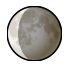

In [68]:
makeMoonLune(-0.2)

<function matplotlib.pyplot.show(close=None, block=None)>

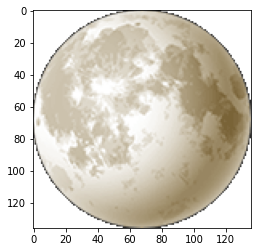

In [12]:
pathToResources = ".\\resources\\"
imageRef = pathToResources + 'FullMoon.png' # fetch locally (way faster on a pi)
imageOverlay = plt.imread(imageRef)
(hgt,wdt,cols) = imageOverlay.shape
#plt.figure(figsize=(3, 3))

implot = plt.imshow(imageOverlay)
plt.show()

---
# Tide Experimental Section
Below here are the experiments that led to the above routines.

## REST Method for Tide Data

Tide data can be fetched via a REST call outlined below.  This is the testing area for the development of the fetchTideData method listed above.

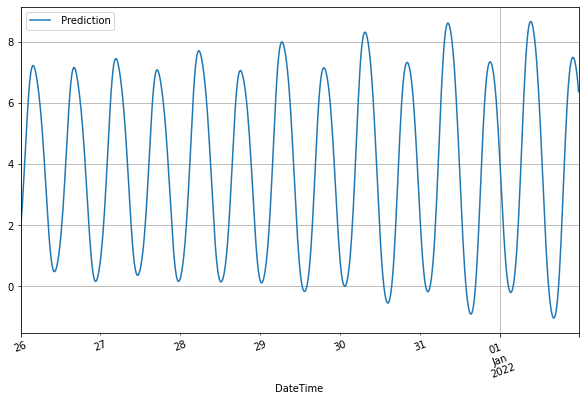

In [ ]:
#@ title REST Parameters
startD = date(2021, 12, 26)  # GMT time so that
endD = date(2022, 1, 1)

startDate = startD.strftime("%Y%m%d")
endDate = endD.strftime("%Y%m%d")
stations = {'NewRochelleNY':  "8518490",
            'RyePlaylandNY':  "8518091",
            'CosCobCT':       "8469549",
            'ThrogsNeckBrNY': "8518526",
            'KingsPointNY':   "8516945",
            'BatteryNY':      "8518750",
            'BridgeportCT':   "8467150",
            'NewHavenCT':     "8465705",
            "NewboldPA":      "8548989",
            'TurkeyPointNY':  "8518962",
            }

station = stations['RyePlaylandNY']
units = "english" # "metric"
# interval = "hilo"  # hi and lo tides
# interval = "h"     # hourly
interval = "15"      # 30,15,6,1 min
datum = "MLLW" # "STND" "MHHW" "MHW" "MTL" "MLW" "MLLW" "NAVD"
timezone = "LST_LDT" # "LST" or "GMT"
clock = "24hour" # "12hour"

noaaSite = f"https://tidesandcurrents.noaa.gov/api/datagetter?product=predictions&application=NOS.COOPS.TAC.WL&begin_date={startDate}&end_date={endDate}&datum={datum}&station={station}&time_zone={timezone}&clock={clock}&units={units}&interval={interval}&format=csv"

tideDF = pd.read_csv(noaaSite)
try:
  # convert string dates to proper date times
  tideDF['DateTime'] = tideDF['Date Time'].apply(lambda x:datetime.strptime(x, "%Y-%m-%d %H:%M"))
  minTime = tideDF['DateTime'].min()
  tideDF['hours'] = tideDF['DateTime'].apply(lambda x:(x-minTime).total_seconds()/3600)
  tideDF.plot('DateTime', ' Prediction', figsize=(10, 6), rot=20, grid=True)
except:
  print(tideDF)


In [25]:
#@title Make graphical simulation of NOAA chart
def makeTideGraph(detailDF, extremaDF):
    """
    Make tide ala NOAA from two sets of pandas DataFrames:
    detailDF -- Detailed predicted water levels for complete graph
    extremeDF -- The extrema (highs and lows)
    """
    global gTideUnit # unit switch flag

    graphFile = "resources/tmp/TideGraph.png"

    import matplotlib.transforms
    import matplotlib.dates as mdates

    today = datetime.now(tz=EST).date()

    # Set up the plot and plot the data
    # px = 1/plt.rcParams['figure.dpi']  # pixel in inches (doesn't work if bbox is 'tight')
    fig, ax = plt.subplots(figsize=(12, 4))

    ax.plot(detailDF['DateTime'], detailDF[gTideUnit], color="blue", alpha=0.8)

    # Markers at extrema with square marks
    ax.scatter(extremaDF['DateTime'], extremaDF[gTideUnit], color="blue", marker="s")
    for index, row in extremaDF.iterrows():
        xy = (row['DateTime'], row[gTideUnit])
        u = gTideUnit.split("[")[1].split("]")[0]   # row['Units']
        ax.annotate(f'{xy[1]:5.2f} {u[:2]}', xy=xy, xytext=(8,0), textcoords='offset points', color='blue')

    # Set the axis labels
    # ax.set_xlabel("Date and Time", fontsize=14, fontstyle='italic', color='SlateGray')
    ax.set_ylabel(f"Tide Level in {u}", fontsize=14, fontstyle='italic', color='SlateGray')
    # ~put an alternate axis in meters~ Alternate between meters and feet in 5min intervals

    # Put a vetical bar that marks right now.
    now = datetime.now(tz=EST)
    (ymin, ymax) = ax.get_ylim()
    ax.annotate(f"Current Time   {now.time().strftime('%I:%M %p')}", xy=(now, (ymin+ymax)/2), xytext=(-15,-30), textcoords='offset points', color='green', rotation=90.0, alpha=0.6 )
    ax.vlines(now, ymin=ymin, ymax=ymax, transform=ax.get_xaxis_transform(), colors="green", linewidth=4, alpha=0.7)

    #Fix the time axis
    ax.xaxis.set_major_locator(mdates.DayLocator(tz=EST))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4, tz=EST))

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d', tz=EST))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M', tz=EST))

    dx = 0.; dy = -10/72.
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    # Create offset transform by 5 points in x direction
    for label in ax.xaxis.get_majorticklabels():
        label.set(horizontalalignment='center', color="darkred", fontweight='bold')
        label.set_transform(label.get_transform() + offset)

    for label in ax.xaxis.get_minorticklabels():
        label.set(horizontalalignment='center', color="darkred")

    ax.grid(True, which='major', linewidth=2, axis='both', alpha=0.7)
    ax.grid(True, which='minor', linestyle="--", axis='both', alpha = 0.5)

    fig.show()
    #fig.savefig(graphFile, bbox_inches='tight', transparent=True)
    plt.close(fig)


### Run the Graph

### Cross correlations

In [ ]:
startD = date(2021, 12, 25)
endD = date(2021, 12, 30)

ryeDF = fetchTideData(stations['RyePlaylandNY'], startD, endD)
otherDF = fetchTideData(stations['TurkeyPointNY'], startD, endD)

plt.plot(ryeDF['Hours'],ryeDF['Prediction'], color="blue", alpha=0.8)
plt.plot(otherDF['Hours'], otherDF['Prediction'], color="red", alpha=0.8)
plt.show()

You would expect to see some phase shift of tides as you move to the east or west.  (Or up an estuary)

### Harmonic Constants for a given station

With a station number we can get the parameters that predict the tide for a given location given the following parameters from NOAA.

 - Constituent #
 > Order in which the National Ocean Service lists the constituents
 - Name
 > Common name used to refer to a particular constituent, subscript refers to the number of cycles per day
 - Amplitude $A_i$
One-half the range of a tidal constituent. (*In other words the standard definition of amplitude*)
 - Phase $\Phi_i$ (*the phase of this component relative to the others*)
 > The phase lag of the observed tidal constituent relative to the theoretical equilibrium tide. = $\frac{180}{\pi}\phi$
 - Speed $\Omega_i$ (*the angular speed, a.k.a. angular frequency associated with this component*)
 > The rate change in the phase of a constituent, expressed in degrees per hour. The speed is equal to 360 degrees divided by the constituent period expressed in hours. = $\frac{180}{\pi}\;3600\;\omega$ where $\omega$ is in $rad/s$
 - Description
 > The full name of the tidal constituent

Amplitudes are in feet. Phases are in degrees, referenced to Local. Z0 (MSL): 0 feet.

The basic model would be cast as...
$$\sum_{i=1}^{32} A_i \cos(\phi_i + \omega_i t)$$

or

```python
phi   = np.pi/180. * Phase
omega = np.pi/180 * Speed / 3600.
amp   = Amplitude
```

The piece that is missing here is exactly from when do we measure the highest tide to start the calculation. From reading various reports and documents I gather that this time shift factor is reset every few years to make sure the calculation matches up with the measurements (NOAA is always checking against actual readings.)



In [ ]:
#@title Harmonic Constants for Rye Playland Beach
site = "https://tidesandcurrents.noaa.gov/harcon.html?id=" + stations['RyePlaylandNY']

constDF = pd.read_html(site, header=0)[0]
constDF['phi'] = constDF['Phase'] * np.pi / 180.0
constDF['omega'] = constDF['Speed'] * np.pi / 180.0 / 3600.0

coefs = constDF[['Amplitude','phi','omega']].to_numpy()

In [ ]:
#@markdown `tide` calculates the amplitude based on the parameters
def tide(terms, time):
  tideLevel = 0.0
  for [amp,phi,omega] in terms:
    tideLevel += amp * np.cos(omega * time + phi)
    # for point of reference this takes about 50 lines of Fortran Code
  return tideLevel

# initialize the arrays
hours = np.array([])
hgt = np.array([])

# this ought to be 'vectorizable' but I can't seem to get it to work.
for h in range(3*24): # a week
  hours = np.append(hours, h)
  hgt = np.append(hgt, tide(coefs, h*3600))

plt.plot(hours,hgt)

plt.show()

Superimpose the harmonic estimation with the data passed from a REST call to the NOAA site.

In [ ]:
startD = datetime(2021, 12, 20, 2, 0, tzinfo=EDT)
endD = datetime(2021, 12, 30, 2, 0, tzinfo=EDT)

tideDF = fetchTideData(stations['RyePlaylandNY'], startD, endD)

d1 = tideDF['DateTime'].min() #datetime(2021, 12, 28, 0, 0, 0, tzinfo=EDT)
d2 = tideDF['DateTime'].max() #datetime(2021, 12, 30, 8, 0, 0, tzinfo=EDT)

hgt = np.array([])

intrv = np.linspace(d1.toordinal()*24, 24+d2.toordinal()*24, num=300, endpoint=True)
shift = 12.2  # time phase shift
for i in intrv:
  hgt = np.append(hgt, tide(coefs, (i-shift)*3600))


plt.figure(figsize=(20,6))
# Plot the harmonic values
plt.plot((intrv-intrv.min()), hgt+3.5)
plt.xticks([i for i in range(0,260,12)])


restHours = tideDF['Hours'].to_numpy()
restAmp = tideDF['Prediction'].to_numpy()

plt.scatter(restHours, restAmp, alpha=0.6)
plt.grid(True)
plt.show()


## Tide Clock Design Notes

So how to make an easily seen display of the tide situation. I have in my hardware kits:
  - Nested NeoPixel Wheels, a stack of 1+8+12+16+24+32 or 61 pixels in total
  - individual neopixels galore
  - Mechanical indicators are not out of the question.
  - How about a discarded 720p display in a case run by a Raspberry Pi?



### Round 1

Use an old Dell Screen which was to be decommisioned.
  - Program a **Raspberry Pi B v1.1** to drive the screen
      - Design and layout the graphics
      - Power the ℿ from the 12V audio connection (*Buck converter*)
  - Build a 'weather resistant' case from wood and plexi.
  - Design a mount for placing where the clock was.

Need to consider things to put on the screen (plenty-o real estate)
  - The graph of the next 48 hours (format the way NOAA does it)
  - The time of the next tide extrema (high or low)
  - Moon phase?
  - subtle clues as to when the last access of NOAA data was.
  - Grab data from NOAA in a responsible way (once every 24 hours?)
  - Today's Date (of course)
  - Weather data?

References:
 - [Rye Playland, Harmonic Calculations](https://tidesandcurrents.noaa.gov/noaatidepredictions.html?id=8518091)  Harmonic estimates checked against measurements.
 - [Larchmont Harbor, NY](https://marine.weather.gov/MapClick.php?lat=40.9251&lon=-73.7391#.YdDNYWjMIkk)  Gives the marine version of the weather.


We need to understand how dates work in python.

After some side explorations I now understand date, time and datetime and the proper way to shift time values.  Short caption: always try to work with 'aware' time values.

For example: date.today() returns the date at UTC, which means if I want the date for here (UTC-4,5) the date will be wrong.  Solution: start with 'aware' datetimes

These are global values used with subsequent cells

In [ ]:
# With each call we flip the units so we toggle back and
#      forth between metric and imperial (we have an international audience)
idx = 0
measure = ("english", "metric")
stations = {'NewRochelleNY':  "8518490",
            'RyePlaylandNY':  "8518091",
            'CosCobCT':       "8469549",
            'ThrogsNeckBrNY': "8518526",
            'KingsPointNY':   "8516945",
            'BatteryNY':      "8518750",
            'BridgeportCT':   "8467150",
            'NewHavenCT':     "8465705",
            "NewboldPA":      "8548989",
            'TurkeyPointNY':  "8518962",
            }

tideStation = stations['RyePlaylandNY']

We don't want to be hammering on the NOAA servers every 5 minutes so lets download the tide data once per day and save it.  This cell developes the way to do this.

In [4]:
#@title fetchDailyTides
def fetchDailyTides(fromTideStation):
    """
    """
    detailTidesFile = 'DetailTides.zip'  # 15 minute intervals (for smooth graph)
    extremTidesFile = 'ExtremTides.zip'  # Just the hi and low values for extrema

    # Fetch this data once per day.  And run all the subsequent graphics from this.
    now       = datetime.now(tz=EDT)
    today     = now.date()

    # Proper way to set up timeshifts.
    yesterday = now - timedelta(days=0)
    tomorrow  = now + timedelta(days=2)
    # print(f"today: {today} yesterday:{yesterday} tom:{tomorrow}")

    # look for existing data, if not found: create, if found: load and test for age
    try:
        # print("Try to read saved data...")
        tideDetailDF = pd.read_pickle(detailTidesFile, compression='infer')
        tideExtremDF = pd.read_pickle(extremTidesFile, compression='infer')
    except FileNotFoundError:
        # print("File doesn't exist, creating...")
        # Get the data
        tideDetailDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date())
        tideDetailDF.to_pickle(detailTidesFile, compression='infer')
        tideExtremDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date(), interval='hilo')
        tideExtremDF.to_pickle(extremTidesFile, compression='infer')

    # test detail data frame for age...
    if tideDetailDF['DateTime'][1].date()!=today:
        tideDetailDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date())
        tideDetailDF.to_pickle(detailTidesFile, compression='infer')

    # test extrema data frame for age...
    if tideExtremDF['DateTime'][1].date()!=today:
        tideExtremDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date(), interval='hilo')
        tideExtremDF.to_pickle(extremTidesFile, compression='infer')

    # print(f"15min file: {tideDetailDF['DateTime'][1].date()} curr:{today}")
    # print(f"Extrm file: {tideExtremDF['DateTime'][0].date()} curr:{today}")
    return (tideDetailDF, tideExtremDF)


In [5]:
(ryeDF, ryeDFExt) = fetchDailyTides(tideStation)
ryeDFExt.head()

Try to read saved data...


,Date Time,Tide [ft],Type,DateTime,Hours,Date,Time,Tide [m],Units
0,2022-01-05 00:43,7.443,H,2022-01-05 00:39:00-05:00,0.000000,2022-01-05,00:43,2.268626,ft Feet
1,2022-01-05 07:01,-0.470,L,2022-01-05 06:57:00-05:00,6.300000,2022-01-05,07:01,-0.143256,ft Feet
2,2022-01-05 12:59,8.035,H,2022-01-05 12:55:00-05:00,12.266667,2022-01-05,12:59,2.449068,ft Feet
3,2022-01-05 19:43,-0.857,L,2022-01-05 19:39:00-05:00,19.000000,2022-01-05,19:43,-0.261214,ft Feet
4,2022-01-06 01:37,7.298,H,2022-01-06 01:33:00-05:00,24.900000,2022-01-06,01:37,2.224430,ft Feet


Pull the data from the store and generate a plot that resembles the NOAA tide graph.  I chose this because I like the way it presents the tide data.

### Other Ideas

#### Weather

Developed the principal graphics and tables, now pull in weather information from [marine NOAA site](https://marine.weather.gov/MapClick.php?lat=40.9251&lon=-73.7391#.YdIjbWjMIkm)



In [ ]:
weatherSite = "https://marine.weather.gov/MapClick.php?lat=40.9251&lon=-73.7391#.YdIjbWjMIkm"
weatherDF = pd.read_html(weatherSite)

[Weather API](https://www.weather.gov/documentation/services-web-api)
May be able to provide some direct help.

Use this to get the map grid to get the location
    https://api.weather.gov/points/{latitude},{longitude}

```
    "properties": {
        "@id": "https://api.weather.gov/points/40.9251,-73.7390999",
        "@type": "wx:Point",
        "cwa": "OKX",
        "forecastOffice": "https://api.weather.gov/offices/OKX",
        "gridId": "OKX",
        "gridX": 40,
        "gridY": 45,
        "forecast": "https://api.weather.gov/gridpoints/OKX/40,45/forecast",
        "forecastHourly": "https://api.weather.gov/gridpoints/OKX/40,45/forecast/hourly",
        "forecastGridData": "https://api.weather.gov/gridpoints/OKX/40,45",
        "observationStations": "https://api.weather.gov/gridpoints/OKX/40,45/stations",
        "relativeLocation": {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [
                    -73.751959999999997,
                    40.925961000000001
                ]
            },
            "properties": {
                "city": "Larchmont",
                "state": "NY",
                "distance": {
                    "unitCode": "wmoUnit:m",
                    "value": 1084.6714461509
                },
                "bearing": {
                    "unitCode": "wmoUnit:degree_(angle)",
                    "value": 95
                }
            }
        },
```

In [ ]:
# !curl "https://api.weather.gov/points/40.9251,-73.7391"
!curl "https://api.weather.gov/gridpoints/OKX/40,45/forecast"

{
    "correlationId": "374a5d1e",
    "title": "Unexpected Problem",
    "type": "https://api.weather.gov/problems/UnexpectedProblem",
    "status": 500,
    "detail": "An unexpected problem has occurred.",
    "instance": "https://api.weather.gov/requests/374a5d1e"
}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   269  100   269    0     0    269      0  0:00:01 --:--:--  0:00:01   747


#### Moon Phase

Moon phase with slight background
The URL is a complicated but accurate description of phase e.g.  moon_day_[] where brackets are replaced with...
 - WaxC_## | WaxG_##  (*C*rescent, *G*ibbous)
    - where ## in % in increments
 - first, last, full, new

![waxing 35%](https://www.moongiant.com/images/today_phase/moon_day_WaxG_95.jpg)

Large moon phase based on % provided in URL
![Moon phase based on %#](https://nineplanets.org/static/lib/astro/images/shadow-80.png)

#### Direct observation of tides

In [ ]:
%%html
#<iframe src="https://www.wpc.ncep.noaa.gov/basicwx/bwxloop_ndfd.html" width="1100px" height="820px"></iframe>

[Mamaroneck Web Cam](https://www.weatherbug.com/weather-camera/?cam=MMBPC) for checking the tides?

---
# Implementation Experimentation
Below here are experiments in persistance between executions and interacting with the OS

This is an experimental area for exploring how to implement permanence across executions.
Environmental variables are things that are read but not saved in the shell environment. So we need a better way to save the state of our envgine.  python has a native library called [configparser](https://docs.python.org/3/library/configparser.html) which handles much of the overhead internally.

In [ ]:
import configparser
buildconfig = configparser.ConfigParser()

# quick setup and definition
buildconfig['DEFAULT'] = {'TideUnits': 'Tide [ft]',
                     'Yesterday': 0,
                     'Tomorrow': 2,
                     # Rye Playland, NY (Harmonic Station)
                     'Station': 8518091
                     }

# funny, we can read
with open('.env', 'w') as envFile:
    buildconfig.write(envFile)


In [ ]:
#
config = configparser.ConfigParser()
config.read('.env')
defaults = config['DEFAULT']

print([f"{k}: {v}" for (k,v) in defaults.items()])

tideUnits = defaults.get('tideunits','Tide [ft]')
yesterdayDelta = defaults.getint('yesterday', fallback=-1)
tomorrowDelta = defaults.getint('tomorrow', fallback=3)
station = defaults.get('station')
print(f"'{tideUnits}' '{station}' {yesterdayDelta}-{tomorrowDelta}")


In [ ]:
defaults['tideunits']  = 'Tide [cubit]'

# only way to save, as mentioned above, it can read with a string to the file but
# requires this additional overhead to save.
with open('.env', 'w') as envFile:
    config.write(envFile)

In [ ]:
gv = 1

def incr2():
    global gv, ev, ov
    gv += 2

def incr1():
    # doesn't work
    gv = 22

def oper():
    print(gv)
    incr1()
    print(gv)
    incr2()
    print(gv)

oper()

In [ ]:
#import config

config.a = 1
config.b = 'two'

In [ ]:
graphFile = 'graphic.png'
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from pytz import timezone  # should already be part of pandas but it doesn't hurt to do it again.
EST = timezone('America/New_York')

# Getting Weather Data
import html5lib
import pandas as pd

now = datetime.now(tz=EST)

windDF = pd.read_html("https://www.ndbc.noaa.gov/station_page.php?station=44022", match='Previous observations', header=1)[0]
windDF['Time'] = windDF['TIME(EST)'].apply(lambda t: datetime.strptime(t, "%I:%M %p").replace(tzinfo=EST).time())
windDF['Date'] = windDF[['MM','DD']].apply(lambda md: date(year=now.year, month=md[0], day=md[1]), axis=1)   #print(f"{md[0]}-{md[1]}")
windDF['DateTime'] = windDF[['Date','Time']].apply(lambda dt: datetime.combine(dt[0], dt[1], tzinfo=EST), axis=1)



windDF.plot('DateTime', 'WSPDkts')
plt.grid(True)
plt.ylabel("Wind Speed [knts]")


In [ ]:
import matplotlib.transforms
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(windDF['DateTime'], windDF['WSPDkts'], 'bo', alpha=0.8)

# Set the axis labels
ax.set_xlabel("Date and Time", fontsize=10, fontstyle='italic', color='SlateGray')
ax.set_ylabel("Wind Speed [knts]", fontsize=10, fontstyle='italic', color='SlateGray')

#Fix the time axis
ax.xaxis.set_major_locator(mdates.DayLocator(tz=EST))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4, tz=EST))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d', tz=EST))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M', tz=EST))

dx = 0.; dy = -10/72.
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
# Create offset transform by 5 points in x direction
for label in ax.xaxis.get_majorticklabels():
    label.set(horizontalalignment='center', color="darkred", fontweight='bold')
    label.set_transform(label.get_transform() + offset)

for label in ax.xaxis.get_minorticklabels():
    label.set(horizontalalignment='center', color="darkred")

ax.grid(True, which='major', linewidth=2, axis='both', alpha=0.7)
ax.grid(True, which='minor', linestyle="--", axis='both', alpha = 0.5)
ax.set_ylim(bottom=0.0)

#fig.show()
fig.savefig(graphFile, bbox_inches='tight')
plt.close(fig)

---
# Wind Data
There are actual data stations within a few klicks of our YC so why not use some of our real estate to display the information?  One thing to worry about is that 2 of the data stations are buoys: accurate when you can get the data but unreliable at times.

In [26]:
#@title test of gathering wind data.
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta
from pytz import timezone  # should already be part of pandas but it doesn't hurt to do it again.

EST = timezone('America/New_York')
UTC = timezone('UTC')

import matplotlib.transforms
import matplotlib.dates as mdates

# Getting Weather Data from execution rocks (station 44022)  Only needs to run every 15 minutes.

In [34]:
# Exscution Rocks weather buoy
realEXR_TimeDataFile = "https://www.ndbc.noaa.gov/data/realtime2/44022.txt"  # May not be available
# Kings Point
realKPS_TimeDataFile = "https://www.ndbc.noaa.gov/data/realtime2/KPTN6.txt"  # Maintained by the US Merchant Marine Academy
# Western Long Island Sound
realWLI_TimeDataFile = "https://www.ndbc.noaa.gov/data/realtime2/44040.txt" # May not be available

### Fetch Wind Data

In [82]:
def fetchWindData(dataSetSite):
  now = datetime.now(tz=EST)
  def filtMM(x):
    x[x != 'MM'].apply(float)
#    x[x == 'MM'] = 5000.

  windDF = pd.read_csv(dataSetSite, sep="\\s+", header=[0,1], nrows=450, na_values='MM' ) # Deprecated: , delim_whitespace=True
  print(f"\t...got {len(windDF)} data values")
  #print(windDF.columns)

  windDF['DateTime'] = windDF[['#YY','MM','DD','hh','mm']].apply(lambda dt: datetime(dt[0], dt[1], dt[2], dt[3], dt[4], tzinfo=UTC).astimezone(EST), axis=1)
  #windDF['DateTime'] = windDF[['#YY','MM','DD','hh','mm']].apply(lambda dt: datetime(dt['#YY'], dt['MM'], dt['DD'], dt['hh'], dt['mm'], tzinfo=UTC).astimezone(EST), axis=1)
  windDF['Time'] = windDF['DateTime'].apply(lambda t: t.time())
  windDF['Date'] = windDF['DateTime'].apply(lambda d: d.date())
  # windDF['WDIR'] = windDF['WDIR'].apply(filtMM)
  # windDF['GST'] = windDF['GST'].apply(filtMM)
  # windDF.index = windDF['DateTime']

  return windDF #.set_index(windDF['DateTime'] - windDF['DateTime'].min()) # returns a new copy
#  return windDF.set_index('DateTime')


In [83]:
df = fetchWindData(realKPS_TimeDataFile)
df.head()

	...got 450 data values


/tmp/ipykernel_27295/1867080078.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  windDF['DateTime'] = windDF[['#YY','MM','DD','hh','mm']].apply(lambda dt: datetime(dt[0], dt[1], dt[2], dt[3], dt[4], tzinfo=UTC).astimezone(EST), axis=1)


,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,...,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE,DateTime,Time,Date
,#yr,mo,dy,hr,mn,degT,m/s,m/s,m,sec,...,hPa,degC,degC,degC,nmi,hPa,ft,,,
0,2025,2,10,20,30,330.0,6.2,7.7,NaN,NaN,...,1027.3,1.9,1.9,NaN,NaN,NaN,NaN,2025-02-10 15:30:00-05:00,15:30:00,2025-02-10
1,2025,2,10,20,24,320.0,5.7,6.7,NaN,NaN,...,1027.3,1.9,1.9,NaN,NaN,NaN,NaN,2025-02-10 15:24:00-05:00,15:24:00,2025-02-10
2,2025,2,10,20,18,NaN,NaN,NaN,NaN,NaN,...,NaN,1.8,1.9,NaN,NaN,NaN,NaN,2025-02-10 15:18:00-05:00,15:18:00,2025-02-10
3,2025,2,10,20,12,NaN,NaN,NaN,NaN,NaN,...,NaN,1.8,1.8,NaN,NaN,NaN,NaN,2025-02-10 15:12:00-05:00,15:12:00,2025-02-10
4,2025,2,10,20,6,NaN,NaN,NaN,NaN,NaN,...,NaN,1.8,1.8,NaN,NaN,NaN,NaN,2025-02-10 15:06:00-05:00,15:06:00,2025-02-10


In [ ]:
# df['GST']=df['GST'].replace({'MM':0})
# df['PRES']=df['PRES'].replace({'MM':800})
sel = df['GST']!='MM'
dfm = df[sel['m/s']]
ndfm = dfm.apply(lambda x: print(x), axis=1, raw=True)
# dfm.applymap(lambda x: float(x))
# n = len(dfm['GST'])

# for i in ndfm['GST']['m/s'].keys():
#     if type(ndfm['GST']['m/s'][i]) is str:
#         print(f"{i}: '{ndfm['GST']['m/s'][i]}'")
#     else:
#         print(f"{i}: {10.0*ndfm['GST']['m/s'][i]}")


In [ ]:
now = datetime.now().astimezone(EST)
d = timedelta(days = 2)
sel = (df['DateTime'] > (now - d)).to_numpy()
ndf = df.resample('2h', on='DateTime').mean()
ndf.head()


In [76]:
ndf.shape

(450, 22)

### Graph the wind data

In [94]:
def makeWindGraph(windDF):
  graphFile = "resources/WindGraph.png"
  fig, ax = plt.subplots(figsize=(8, 4))

  tme = windDF.index
  wspd = windDF['WSPD'] # windDF['WSPD']
  mxsp = windDF['GST'] # windDF['GST']

  ax.plot(tme, wspd/0.447, 'bo-', alpha=0.8)
  ax.plot(tme, mxsp/0.447, 'ro-', alpha=0.8)

  ax.set_ylim(bottom=4.0)

  yloc = 3 * wspd  / wspd
  angl = windDF['WDIR']
  ax.quiver(tme, yloc, np.cos(np.pi*angl/np.pi), np.sin(np.pi*angl/np.pi), angles='uv', color='orange', alpha=0.6, pivot='middle')

  # Set the axis labels
  # ax.set_xlabel("Date and Time", fontsize=10, fontstyle='italic', color='SlateGray')
  ax.set_ylabel("Wind Speed [mph]", fontsize=12, fontstyle='italic', color='SlateGray')

  #Fix the time axis
  ax.xaxis.set_major_locator(mdates.DayLocator(tz=EST))
  ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4, tz=EST))

  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d', tz=EST))
  ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M', tz=EST))

  dx = 0.; dy = -10/72.
  offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
  # Create offset transform by 5 points in x direction
  for label in ax.xaxis.get_majorticklabels():
      label.set(horizontalalignment='center', color="darkred", fontweight='bold')
      label.set_transform(label.get_transform() + offset)

  for label in ax.xaxis.get_minorticklabels():
      label.set(horizontalalignment='center', color="darkred")

  ax.grid(True, which='major', linewidth=2, axis='both', alpha=0.7)
  ax.grid(True, which='minor', linestyle="--", axis='both', alpha = 0.5)
  ax.set_ylim(bottom=0.0)

#  fig.show()
  fig.savefig(graphFile, bbox_inches='tight', transparent=True)
  plt.close(fig)


### Main

In [ ]:
print("Build wind graph...")

now = datetime.now().astimezone(EST)
d = timedelta(days = 2)

theDF = fetchWindData(realKPS_TimeDataFile)

smpl = theDF['DateTime'] > (now - d)
makeWindGraph( theDF[smpl].resample('2h', on='DateTime').mean() )
# print(theDF.rank)


## US Naval Observatory 
gives us sunrise and sunset data, They had a nice REST call 
and I had a working routine for 3 months when it went silent.

In [ ]:
# Launch the following simple server
# python -m http.server --bind localhost --cgi 8000

import json
# import cgi
# A logging tool for debugging.
# dbgReport = None

# import urllib library
from urllib.request import urlopen

###
# Time libraries we are very dependant on 'aware' times. Most bugs have been traced back
# to a misunderstanding of how important that times be 'aware'.
from datetime import tzinfo, timedelta, datetime, date
from pytz import timezone  # should already be part of pandas but it doesn't hurt to do it again.
from dateutil import parser
import time
EST = timezone('America/New_York')

##
#  Returns the appropriate string value for the REST call
##
def isDST(theDate):
    earlyDate = datetime(theDate.year, 2, 13, 2, tzinfo=EST)
    lateDate  = datetime(theDate.year, 10, 6, 2, tzinfo=EST)

    if theDate > earlyDate and theDate <= lateDate:
        return "true"
    return "false"

###
#  Fetch the data from the data from the USNO server
###
def fetchOneDayData(theDate, latlong="40.93,-73.76", timezone="-5"):
    date = theDate.strftime("%m/%d/%Y")
    dst = isDST(theDate)
    id = "HHYC_019E3"

    url = f"https://aa.usno.navy.mil/api/rstt/oneday?id={id}&date={date}&coords={latlong}&tz={timezone}&dst={dst}"
    # dbgReport.write(f"--- {url}\r")
    print(url)
    # store the response of URL
    response = urlopen(url)

    # storing the JSON response from url in data
    return json.loads(response.read())

################################################################

# simulated input comment the next 4 lines when running standalone... fix the '.value' entries below.
fs = { "date":   "2/5/2022", "coords": "40.93,-73.76", }

theDate = datetime.now(tz=EST)

coord = "40.93,-73.76"  # default location
tz = "-5" # default timezone

if "date" in fs:
    passedDate = fs['date'] #.value
    theDate = datetime.strptime(passedDate, "%m/%d/%Y").replace(tzinfo=EST)

if "coords" in fs:
    coord = fs['coords'] #.value

if "tz" in fs:
    tz = fs['tz'] #.value

result = fetchOneDayData(theDate, latlong=coord, timezone=tz)


print("Content-Type: application/json\n")
print(json.dumps(result))


https://aa.usno.navy.mil/api/rstt/oneday?id=HHYC_019E3&date=02/05/2022&coords=40.93,-73.76&tz=-5&dst=false
Content-Type: application/json

{"apiversion": "3.0.0", "geometry": {"coordinates": [-73.76, 40.93], "type": "Point"}, "properties": {"data": {"closestphase": {"day": 8, "month": 2, "phase": "First Quarter", "time": "08:50", "year": 2022}, "curphase": "Waxing Crescent", "day": 5, "day_of_week": "Saturday", "fracillum": "23%", "isdst": false, "label": null, "month": 2, "moondata": [{"phen": "Rise", "time": "09:40"}, {"phen": "Upper Transit", "time": "15:57"}, {"phen": "Set", "time": "22:24"}], "sundata": [{"phen": "Begin Civil Twilight", "time": "06:33"}, {"phen": "Rise", "time": "07:01"}, {"phen": "Upper Transit", "time": "12:09"}, {"phen": "Set", "time": "17:17"}, {"phen": "End Civil Twilight", "time": "17:46"}], "tz": -5.0, "year": 2022}}, "type": "Feature"}


## Extracting Graphical Data

Execution rocks only provide png graphics so the question is: can we dice up the `pngs` to get what we want for wind and waves?

**YES** It wasn't even hard. The real worry was that the Kiosk couldn't handle it. The simplicity of the graphic helped. The final code 
only required about 45s to run.  The change requires that the kiosk remain on 24/7 as it now runs the accumulation package that stores 
data from the wind and wave panel in a local database. The graphic generator now draws its data from these files.

In [ ]:
executionWeather = "https://clydebank.dms.uconn.edu/exrx_wxSens.png"
executionWaves   = "https://clydebank.dms.uconn.edu/exrx_wavs.png"

In [ ]:
import requests
from PIL import Image
from io  import BytesIO

def fetch_and_crop_image(url, xs, ys, width, height):
    # Fetch the image from the web
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    # Crop the image
    cropped_img = img.crop((xs, ys, xs + width, ys + height))

    return cropped_img


### Exploration of Regions to Extract

In [10]:
# Weather Panel:
xs, ys, width, height = 0, 0, 640, 480
cropped_image = fetch_and_crop_image(executionWeather, xs, ys, width, height)
# Display the cropped image
cropped_image.show()

# Wave Panel:
cropped_image = fetch_and_crop_image(executionWaves, xs, ys, width, height)
# Display the cropped image
cropped_image.show()

In [17]:
# Time Slugs:
xs, ys, width, height = 98, 64, 197, 18
cropped_image = fetch_and_crop_image(executionWeather, xs, ys, width, height)
# Display the cropped image
cropped_image.show()

# Wave Panel:
cropped_image = fetch_and_crop_image(executionWaves, xs, ys, width, height)
# Display the cropped image
cropped_image.show()

In [19]:
# Wind Panel:
xs, ys, width, height = 0, 110, 350, 360
cropped_image = fetch_and_crop_image(executionWeather, xs, ys, width, height)

# Display the cropped image
cropped_image.show()

In [3]:
# Temp Data:
xs, ys, width, height = 350, 110, 280, 270
cropped_image = fetch_and_crop_image(executionWeather, xs, ys, width, height)

# Display the cropped image
cropped_image.show()

In [20]:
# Barometric Data:
xs, ys, width, height = 350, 390, 280, 80
cropped_image = fetch_and_crop_image(executionWeather, xs, ys, width, height)

# Display the cropped image
cropped_image.show()

In [9]:
# Wave Data:
xs, ys, width, height = 30, 110, 380, 270
cropped_image = fetch_and_crop_image(executionWaves, xs, ys, width, height)

# Display the cropped image
cropped_image.show()


### Development of the capture code

In [ ]:
# Global definitions
NaN = float('nan')
INDEX = 'TimeStamp' # standard index label for dataframes

# image URIs for Wind information
EXRX_WIND_URL = "https://clydebank.dms.uconn.edu/exrx_wxSens2.png"  # Execution rocks
WLIS_WIND_URL = "https://clydebank.dms.uconn.edu/wlis_wxSens1.png"  # Western Long Island
CLIS_WIND_URL = "https://clydebank.dms.uconn.edu/clis_wxSens1.png"  # Central Long Island

windURLS = {
    'exrx': EXRX_WIND_URL,
    'wlis': WLIS_WIND_URL,
    'clis': CLIS_WIND_URL,
}

# image URIs for Wave information
EXRX_WAVE_URL = "https://clydebank.dms.uconn.edu/exrx_wavs.png"
WLIS_WAVE_URL = "https://clydebank.dms.uconn.edu/wlis_wavs.png"
CLIS_WAVE_URL = "https://clydebank.dms.uconn.edu/clis_wavs.png"

waveURLS = {
    'exrx': EXRX_WAVE_URL,
    'wlis': WLIS_WAVE_URL,
    'clis': CLIS_WAVE_URL,
}

In [ ]:
# dictionary of locations within the image of the data we want.
windSources = {
    INDEX:                {'bounds':(100,  62, 294,  78), 'value': NaN , 'range':           None}, #dateString for reading
    'WindSpeedAvg [kts]': {'bounds':( 21, 307,  63, 327), 'value': NaN , 'range':     (0.0,60.0)}, #kts
    'WindSpeedGst [kts]': {'bounds':(116, 307, 158, 327), 'value': NaN , 'range':     (0.0,60.0)}, #kts
    'WindSpeedAvg [mph]': {'bounds':( 21, 334,  63, 351), 'value': NaN , 'range':     (0.0,70.0)}, #mph
    'WindSpeedGst [mph]': {'bounds':(116, 332, 158, 351), 'value': NaN , 'range':     (0.0,70.0)}, #mph
    'WindSpeedAvg [m/s]': {'bounds':( 21, 358,  63, 375), 'value': NaN , 'range':     (0.0,31.0)}, #m/s
    'WindSpeedGst [m/s]': {'bounds':(116, 358, 158, 375), 'value': NaN , 'range':     (0.0,31.0)}, #m/s
    'WindDir [°]':        {'bounds':(230, 320, 287, 339), 'value': NaN , 'range':   (0,     360)}, #deg True
    'AirTemp [°F]':       {'bounds':(410, 169, 471, 188), 'value': NaN , 'range':  (-20.0,110.0)}, #deg Farenheit
    'AirTemp [°C]':       {'bounds':(409, 221, 471, 238), 'value': NaN , 'range':  (-30.0, 40.0)}, #deg Centegrade
    'BaromPres [mmHg]':   {'bounds':(391, 415, 449, 434), 'value': NaN , 'range':    (25.0,32.5)}, #barm in mmHg
    'BaromPres [mB]':     {'bounds':(467, 415, 537, 434), 'value': NaN , 'range': (850.0,1100.0)}, #barm in mBar
    'DewPoint [°F]':      {'bounds':(505, 322, 552, 341), 'value': NaN , 'range':  (-20.0,110.0)}, #dewpoint deg Farenheit
    'DewPoint [°C]':      {'bounds':(563, 322, 605, 341), 'value': NaN , 'range':  (-30.0, 40.0)}, #dewPoint degCentegrade
    'RelHum [%]':         {'bounds':(391, 323, 448, 341), 'value': NaN , 'range':    (0.0,100.0)}, #rel. humidity
    'WindSpeedM24 [kt]':  {'bounds':(112, 412, 150, 435), 'value': NaN , 'range':     (0.0,60.0)}, #kts max in last 24hrs
    'WindDirM24 [°]':     {'bounds':(271, 412, 300, 433), 'value': NaN , 'range':   (0,     360)}, #deg True in last 24hrs
    'WindTimeM24':        {'bounds':(114, 433, 299, 454), 'value': NaN , 'range':           None}, #dateString of 24Hr Max
}

# dictionary of locations within the image of the data we want.
waveSources = {
    INDEX:                {'bounds':(100,  62, 294,  78), 'value': NaN, 'range':       None}, #dateString for reading
    'WaveHgtSig [ft]':    {'bounds':( 68, 329, 112, 346), 'value': NaN, 'range': (0.0,12.0)}, #ft
    'WaveHgtMax [ft]':    {'bounds':(168, 329, 212, 346), 'value': NaN, 'range': (0.0,12.0)}, #ft
    'WaveHgtSig [m]':     {'bounds':( 68, 353, 112, 371), 'value': NaN, 'range': (0.0, 3.7)}, #m
    'WaveHgtMax [m]':     {'bounds':(168, 353, 212, 371), 'value': NaN, 'range': (0.0, 3.7),}, #m
    'WaveDir [°]':        {'bounds':(292, 320, 347, 340), 'value': NaN, 'range': (  0, 360)}, #degT
    'WavPerAvg [s]':      {'bounds':(479, 193, 539, 211), 'value': NaN, 'range':       None}, #sec
    'WavPerDom [s]':      {'bounds':(479, 251, 539, 269), 'value': NaN, 'range':       None}, #sec
    'WaveHgt24 [ft]':     {'bounds':(169, 413, 207, 433), 'value': NaN, 'range': (0.0,12.0)}, #ft max in last 24hrs
    'WaveDirM24 [°]':     {'bounds':(327, 412, 354, 433), 'value': NaN, 'range': (  0, 360)}, #deg True in last 24hrs
    'WavePerAvgM24 [s]':  {'bounds':(440, 412, 468, 430), 'value': NaN, 'range':       None}, #avg period in last 24hrs
    'WavePerDomM24 [s]':  {'bounds':(540, 412, 570, 430), 'value': NaN, 'range':       None}, #dominant period in last 24hrs
    'WaveTimeM24':        {'bounds':(169, 433, 363, 455), 'value': NaN, 'range':       None}, #dateString of 24Hr Max
}

**Buoy Capture Object** This handles the different screens in an abstract way. It handles the OCR of an information panels and presents the data in a dictionary. 

In [ ]:
class BuoyDataCapture:
    """
    Class to capture data from NERACOOS weather buoys. NERACOOS (long acronym: https://neracoos.org/), capture data from
    floating environmental stations up and down the coast. Mostly, it standardardizes the data storage and engineering of
    these stations. The data can be made available via an API but for the last 18 mos. it has only been available through
    a graphical display. As a consequence, this class uses OCR to read data from images and store the results in this object.
    This class works for both wind and wave data sections.  They have similar layouts. The water chemistry and bathymetry panels
    are quite different and might need a different class but we have what we need for our use case.
    :param sourceImageURL: URL of the image to fetch.
    :param dataExtraction: Dictionary defining regions to extract and store results.
    """

    # Source for image to decode
    sourceURL = ""
    # Placeholder for results
    dataParts = {}
    # temporary holder for downloaded image (maybe keep in memory?)
    filename  = "image.png"
    # Tesseract works best when limiting the characters to look for.
    ocrLimits = { # 0 decode for numbers
        'numberlike': r'--psm 6 -c tessedit_char_whitelist=-0123456789.',
                  # 1 decode for date
        'datelike':   r'--psm 6 -c tessedit_char_whitelist=-0123456789,:\ APMSunMonTueWedThuFriSatJanFebMarAprMayJunJulAugSepOctNovDecESTGMT',
    }

    def __init__(self, sourceImageURL, dataExtraction, filename:None):
        """
        Initialize the class
        :param sourceImageURL: Where we get the original image. The last part of the path will be a valid .png file name.
        :param dataExtraction: The structure (see above) that delineates the bounds we are trying to capture along with a place to store the result.
        """
        dataExtraction = dataExtraction.copy()  # avoid mutating the input dictionary
        self.sourceURL = sourceImageURL
        self.dataParts = dataExtraction
        if filename == None:
            self.filename = sourceImageURL.split("/")[-1]
        else:
            self.filename = filename
        # self.df = pd.DataFrame(columns=dataExtraction.keys())

    def fetch_image(self, filename=None):
        """
        retrieve the png and store to a file
        :param filename:  An optional name for the capture.
        """
        # 1. Retrieve the image  n.b. add a "?###" random number to sidestep local caching (which probably doesn't happen on a direct fetch)
        response = requests.get(self.sourceURL + f"?{np.random.randint(1000)}")

        # 2. Change the stored filename
        if filename != None:
            self.filename = filename

        # Check if the request was successful (HTTP 200)
        if response.status_code == 200:
            # 3. Store to disk for a second step, the image is not large, maybe keep in memory?
            with open(self.filename, "wb") as f:
                f.write(response.content)
            # return filename  # Return path to the stored file
        else:
            raise requests.RequestException(f"Failed to retrieve image. Status code: {response.status_code}")

    def _preprocess_for_ocr(self, croppedImage):
        """
        Improve the image for the OCR process. Mostly used in internally.
        :param croppedImage: an image object retrieved from the cropping process.
        :return: adapted image for OCR step
        """
        # 1. Convert to Grayscale ('L' mode in Pillow)
        gray_crop = croppedImage.convert('L')

        # 2. Resize: Tesseract needs clear, large characters.
        # Upscaling by 2x or 3x often fixes issues with small regions.
        w, h = gray_crop.size

        if os.uname().nodename == "raspberrypi":
            # For RaspPi
            upscaledImage = gray_crop.resize((w * 2, h * 2), Image.LANCZOS)
        else:
            # For high end
            upscaledImage = gray_crop.resize((w * 2, h * 2), Image.Resampling.LANCZOS)

        # 3. Optional: Invert if text is light on a dark background
        # Tesseract expects dark text on a light background.
        # upscaled = ImageOps.invert(upscaled)
        return upscaledImage

    def ocr_numerals_only(self, image_crop, ocrCharacterLimit):
        """
        Processes a cropped image to extract only numbers and decimal points.
        :param image_crop: A single cropped image.
        :param ocrCharacterLimit: A set of characters to use when trying to decode the image
        :return: The value for the image.
        """
        # Configuration breakdown:
        # --psm 6: Assume a single uniform block of text (good for small crops)
        # tessedit_char_whitelist: Restrict characters to digits and dot

        # Perform OCR
        # text = pytesseract.image_to_string(image_crop, config=self.ocrLimits['numberLike'])
        # # Clean up whitespace/newlines
        # return float(text.strip())
        return self._ocr_values(image_crop, self.ocrLimits['numberlike'])

    def ocr_dates_only(self, image_crop):
        """
        Processes image crops to extract only numbers and decimal points.
        :param image_crops: List of PIL Image objects (from previous step).
        :return: List of extracted numeric strings.
        """
        logging.debug("--DATES ONLY--")
        # Configuration breakdown:
        # --psm 6: Assume a single uniform block of text (good for small crops)
        # tessedit_char_whitelist: Restrict characters to digits and dot

        # Perform OCR
        # text = pytesseract.image_to_string(image_crop, config=self.ocrLimits['dateLike'])
        # Clean up whitespace/newlines
        # return text.strip()
        return self._ocr_values(image_crop, self.ocrLimits['datelike'])

    def _ocr_values(self, image_crop, ocrCharacterLimit):
        """
        Processes a cropped image to extract only numbers and decimal points.
        :param image_crop: A single cropped image.
        :param ocrCharacterLimit: A set of characters to use when trying to decode the image
        :return: The value for the image.
        """
        # Perform OCR
        text = pytesseract.image_to_string(image_crop, config=ocrCharacterLimit)
        # Clean up whitespace/newlines
        return text.strip()

    def extract_regions(self):
        """
        Extracts multiple rectangular regions from a PNG.  Again, we store the result
        on disk but maybe we can get away with keeping in memory?
        :param image_path: Path to the retrieved PNG file.
        :param regions: List of 4-tuples (left, upper, right, lower) coordinates.
        :return: List of cropped Image objects.
        """
        # extracted_images = []

        with Image.open(self.filename) as img:
            # Standardize for OCR: convert to RGB and remove transparency
            img = img.convert("RGB")

            for key, item in self.dataParts.items():
                logging.debug(f"WRK: {key}: {item['bounds']} {key.find('Time')}")
                croppedImage = self._preprocess_for_ocr(img.crop(item['bounds']))

                if key.find("Time")>-1:
                    # Decoding the date can be tricky. Though the buoys are connected via cell their clocks can be wildly off.
                    data = self._ocr_values(croppedImage, self.ocrLimits['datelike']) + f", {datetime.now().year}"
                    logging.debug(f"\t\tTime string [raw]: {repr(data)}")
                    # Gemini recommends stripping the timezone from the string and then localizing it to EST. This is because the timezone is often captured as "EST" but the time is actually in EDT during daylight savings time. This is a common issue with OCR of time strings that include timezones. By stripping the timezone and then localizing to EST, we can ensure that we get the correct time regardless of whether it is currently EST or EDT.
                    data = data.replace("EST, ", "").replace("EDT, ", "")
                    logging.debug(f"\t\tTime string [raw]: {repr(data)}")
                    try:
                        data = datetime.strptime(data, "%I:%M:%S %p %a %b %d, %Y")  # even though it captures the EST it is naive
                    except ValueError:
                        try:
                            data = datetime.strptime(data, "%I:%M:%S %p %a%b %d, %Y")  # even though it captures the EST it is naive
                        except ValueError:
                            try:
                                data = datetime.strptime(data, "%I:%M:%S %p %b %d, %Y")  # even though it captures the EST it is naive
                            except ValueError:
                                logging.critical(f"Can't decode date string use current time'{repr(data)}'")
                                data = datetime.now(tz=EST)

                    data = data.replace(tzinfo=EST)
                    logging.debug(f"\t\tTime string [decoded]: {repr(data)}")
                    item['value'] = data + timedelta(minutes=4)
                    #ATTN: When testing this on Jan 02, 2026 the buoy's clock was 2hrs fast. This may be corrected later.
                    # if datetime.now(EST) < data:
                    #     # The buoy reports the wrong time every now and again probably 2 hours off. 1/7/26 Seems to have been fixed.
                    #     logging.debug(f"\t\tFixing time: {repr(data)}")
                    #     data = data - timedelta(hours=2)
                    #     logging.debug(f"\t\t{data}")
                    # else:
                    logging.debug(f"\t\tTime {key} is correct: {repr(item['value'])}")
                        # data = data
                else:
                    try:
                        data = self._ocr_values(croppedImage, self.ocrLimits['numberlike'])
                        data = float(data)
                        # New Feature as of 2/13/26: Test to see if the value is within the expected range. If not, do some additional processing.
                        # Often the OCR in this instance has missed a decimal point. We can try to fix this by dividing by 10 to see if it falls
                        # within the expected range. If not, we can be pretty sure the value is wrong and set it to NaN.  OCR optimization isn't
                        # an option beyond what we have done because of the hardware limitations of the the raspberry pi.  This is a workaround to improve data quality.
                        if 'range' in item and item['range'] is not None:
                            min_val, max_val = item['range']
                            if not (min_val <= data <= max_val):
                                logging.warning(f"Value {data} is outside expected range {item['range']} for key '{key}'")
                                # Try fixing by dividing by 10 and checking if it falls within the expected range
                                data_div10 = data / 10.  # Empirically this is the most common error we see in the OCR results.
                                                         # The OCRed value is 3 sig figs overall but should have 1 decimal value
                                if min_val <= data_div10 <= max_val:
                                    logging.warning(f"Value {data} fixed to {data_div10}")
                                    data = data_div10
                                else:
                                    data = np.nan  # give up and set to NaN if it is still out of range after the fix attempt
                    except:
                        data = np.nan
                item['value'] = data
        # self.df = pd.DataFrame([self.getDict()], index=self.getTime())

    def getDict(self):
        # return all the OCR data without the time index
        # return {k: self[k] for k in self.dataParts if k != INDEX}
        # return all the OCR data
        return {k: self[k] for k in self.dataParts}

    def getNewDFRecord(self):
        """
        Return the time index aware dataframe suitable for concatenation.
        """
        logging.debug(f"New DF Dict:\t{self.getDict()}")
        df = pd.DataFrame([self.getDict()])

        # Select columns with datetime types
        datetime_cols = df.select_dtypes(include=['datetime64[ns, US/Eastern]']).columns
        # Add 4 minutes to the US/Eastern tz columns
        df[datetime_cols] = df[datetime_cols] + pd.Timedelta(minutes=4)
        df[INDEX] = pd.to_datetime(df[INDEX]) # + pd.Timedelta(minutes=4)  # ensure the index is a datetime object and fix the LTZ issue

        df.set_index(INDEX, inplace=True)
        logging.debug(f"New DF Record:\n{df}")
        return df

        # return pd.DataFrame([self.getDict()], index=[self.getTime()])

    def getTime(self):
        return self[INDEX]

    def __getitem__(self, key):
        return self.get(key)

    def get(self, key):
        return self.dataParts[key]['value']


**DataBuffer Object** This handles the different screens in an abstract way. It handles the OCR of an information panels and presents the data in a dictionary.

In [ ]:
class DataBuffer:
    """
    This class manages a ring buffer of data stored in a CSV file. The buffer retains data for the last 3 days (72 hours) only.
    It uses pandas DataFrame for efficient data handling and storage. As with the OCR class above, this class is agnostic toward
    the type of data being stored. It could be data from wind or wave panels. The user specifies the column labels and the class manages
    the rest.
    :param labels: List of strings for the column names. (usually just: `list[waveSources.keys()]` or `list[windSources.keys()]`)
    :param filepath: Path to the CSV file.
    """
    def __init__(self, labels, filepath="sensor_data.csv"):
        """
        :param labels: List of strings for the column names.
        :param filepath: Path to the CSV file.
        """
        self.filepath = filepath
        self.columns = labels

        if os.path.exists(self.filepath):
            # Load existing data and ensure the index is parsed as datetime
            self.df = pd.read_csv(self.filepath, index_col=0, parse_dates=True)
            # Ensure index is timezone-aware (EST) to match new records
            if self.df.index.tz is None:
                self.df.index = self.df.index.tz_localize(EST)
            # Ensure existing columns match the provided labels
            # self.df.columns = self.columns
        else:
            # Initialize empty DataFrame with custom labels and UTC timezone awareness
            #    - 'data=[]' ensures it is empty
            #    - 'tz="US/Eastern"' sets the timezone (you can use 'UTC', 'Asia/Tokyo', etc.)
            tz_aware_index = pd.DatetimeIndex([], dtype='datetime64[ns, US/Eastern]', name=INDEX)
            self.df = pd.DataFrame(columns=self.columns, index=tz_aware_index)

    def add_record(self, newRowDF):
        """
        Appends a dictionary to the dataframe in one step.
        :param data_dict: Dictionary where keys match self.columns.
        """
        # 1. Create a timezone-aware timestamp for the current moment
        # now = data_dict[INDEX]   #datetime.now(UTC)

        # 2. Single-step append: loc automatically maps dictionary keys to columns
        # self.df.loc[now] = data_dict
        #self.df.set_index(INDEX, inplace=True)

        if len(self.df)==0:
            self.df = newRowDF
        else:
            self.df = pd.concat([self.df, newRowDF])

        # 3. Maintain the 3-day ring buffer and save
        self._truncate_and_save()

    def _truncate_and_save(self):
        """Truncates data older than 3 days and saves to CSV to persist through reboots."""
        cutoff_time = datetime.now(EST) - timedelta(days=3)
        # Keep only records from the last 72 hours
        self.df = self.df[self.df.index >= cutoff_time]

        # Remove columns that are completely empty
        df_filtered = self.df.dropna(axis=1, how='all')

        # Export the cleaned DataFrame to CSV
        df_filtered.to_csv(self.filepath)

    def get_data(self):
        """Access the dataframe for graphing or analysis."""
        return self.df

#### Principal Collection Routines

In [ ]:
# foundational libraries
from datetime import datetime, timedelta
# from zoneinfo import ZoneInfo
import pytz  # may need to migrate to ZoneInfo  RaspberryPi OS doesn't have the latest Python and thus doesn't have ZoneInfo.  This is a workaround until we can upgrade the OS.
import requests

# OCR tools
import pytesseract
# Bridge to cli tool. Need to install tesseract-ocr CLI engine in the OS

# Managing images
from PIL import Image

# Data management
import numpy as np
import pandas as pd

import logging
import os

import argparse

### Global Structures and Configurations
# Timezone configuration OLD SCHOOL
UTC = pytz.utc
EST = pytz.timezone('US/Eastern')
# Timezone configuration NEW SCHOOL
# UTC = ZoneInfo('UTC')
# EST = ZoneInfo('US/Eastern')

In [ ]:
def captureWindData(srcURL=EXRX_WIND_URL):
    """
    Docstring for captureWindData
    Capture information from the wind buoy graphical image
    and store it into a database.
    """
    logging.info("-----------------------------------------")
    logging.info("--- Execution Rocks Wind Data Read:")

    wind = BuoyDataCapture(srcURL, windSources, "../resources/tmp/wind_panel.png")
    wind.fetch_image()
    wind.extract_regions()

    logging.debug("time: %s @%s  ", wind[INDEX].strftime('%Y-%m-%d %I:%M:%S %P %Z'), wind[INDEX])

    # # I think this early problem was a one off.
    # if datetime.now(EST) < wind[INDEX]:
    #     logging.warning("Why is the time wrong?")

    logging.info("dataframe:  %s", wind.getNewDFRecord())
    ## Now we want to store this data in a CSV file or a database.
    #
    wind_buffer = DataBuffer(list(windSources.keys()), filepath="../resources/wind_data.csv")
    # Add the new record (automatically handles truncation and saving)
    wind_buffer.add_record(wind.getNewDFRecord())

def captureWaveData(srcURL=EXRX_WAVE_URL):
    """
    Docstring for captureWaveData
    Capture information from the wind buoy graphical image
    and store it into a database.
    """
    logging.info("----------------------------------------")
    logging.info("--- Execution Rocks Wave Data Read:")
    wave = BuoyDataCapture(srcURL, waveSources, "../resources/tmp/wave_panel.png")
    wave.fetch_image()
    wave.extract_regions()

    logging.debug("time: %s @%s", wave[INDEX].strftime('%Y-%m-%d %I:%M:%S %P %Z'), wave[INDEX])

    logging.debug("dataframe:  %s", wave.getNewDFRecord())
    ## Now we want to store this data in a CSV file or a database.
    #
    wave_buffer = DataBuffer(list(waveSources.keys()), filepath="../resources/wave_data.csv")
    # Add the new record (automatically handles truncation and saving)
    wave_buffer.add_record(wave.getNewDFRecord())


```python
def main():
    prog = "captureBuoyData"
    parser = argparse.ArgumentParser(
                    prog=prog,
                    description='Fetches the wind and wave data from LIRACOOS Buoys using OCR techniques.',
                    epilog='')
    parser.add_argument("-z", "--wind",   help="Gather wind information", action='store_true')
    parser.add_argument("-w", "--wave",   help="Gather wave information", action='store_true')
    parser.add_argument("-s", "--source", help="Select buoy to farm", choices=['exrx', 'wlis', 'clis'], default='exrx')
    args = parser.parse_args()

    if args.wind:
        captureWindData(windURLS[args.source])

    if args.wave:
        captureWaveData(waveURLS[args.source])

if __name__ == "__main__":
    logging.basicConfig(filename='../resources/tmp/OCRDataCapture.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    main()
```

### Steal Data from Kiosk
We are not running the capture code 24/7 but the kiosk has been doing this (as of 2/18) for several days:

In [4]:
!scp pi@10.110.110.183:WeatherKiosk/resources/wave_data.csv resources/wave_data.csv
!scp pi@10.110.110.183:WeatherKiosk/resources/wind_data.csv resources/wind_data.csv
!ls -l resources/*.csv

wave_data.csv                                 100%   22KB   2.1MB/s   00:00    
wind_data.csv                                 100%   37KB   1.9MB/s   00:00    
-rw-r--r-- 1 pbeeken pbeeken 22454 Feb 18 15:34 resources/wave_data.csv
-rw-r--r-- 1 pbeeken pbeeken 37768 Feb 18 15:34 resources/wind_data.csv


### Graphic Operations Wind Data

The model here is to read the data based on a cgi-command from the browser at regular intervals to update the graph.  This, initial,
test is designed to mimic the old graph.

In [ ]:
import logging
from datetime import datetime, timedelta
from pytz import timezone  # should already be part of pandas but it doesn't hurt to do it again.

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.transforms
import matplotlib.dates as mdates

EST = timezone('America/New_York')
UTC = timezone('UTC')


```python
# The pwd is the webpage
pathToResources = 'resources/'  # where the data cache and the "static" resources are stored.
pathToImages = 'resources/tmp/'  # where the generated graphs and tables are stored. aja "mutable content"

```

In [ ]:
def fetchWindData(source):
    """
    This gathers the accumulated data from an asynchronous populated datastore by
    OCR the screens from floating buoys out on the sound within a few miles of our club.
    The tabulated data was published by the NWS but UCONN redesigned or had built
    new more robust units but lost the personnel to vet the data so the NWS stopped
    hosting the stream.
    :param source: the path to the file that contains the data store.  We ingest it.
    :return pandas dataframe containing the data.
    """

    logging.info(f"\t...getting from {source}")
    # Getting Weather Data from execution rocks (station 44022)  Only needs to run every 15 minutes.
    windDF = pd.read_csv(source, index_col=0, parse_dates=True)
    windDF.dropna(inplace=True)                                     # wind data has glitches
    logging.info(f"\t...got {len(windDF)} data values")

    # We need to average the components rather than the angles when re-sampling.
    windDF['WdirSin'] = np.sin(np.radians(windDF['WindDir [°]']))
    windDF['WdirCos'] = np.cos(np.radians(windDF['WindDir [°]']))

    return windDF

def windDirection(ang):
    # direction indexer
    labels = {
      'N': (-11.25, 11.25), 'NNE': (11.25, 33.75),   'NE': (33.75, 56.25),   'ENE': (56.25, 78.75),
      'E': (78.75, 101.25), 'ESE': (101.25, 123.75), 'SE': (123.75, 146.25), 'SSE': (146.25, 168.75),
      'S': (168.75, 191.25),'SSW': (191.25, 213.75), 'SW': (213.75, 236.25), 'WSW': (236.25, 258.75),
      'W': (258.75, 281.25),'WNW': (281.25, 303.75), 'NW': (303.75, 326.25), 'NNW': (326.25, 348.75),
    }
    for tag, (min_ang, max_ang) in labels.items():
        if min_ang < ang <= max_ang:
            return tag
    return 'Unknown'


In [ ]:
def makeWindGraph(windDF, whereFrom=""):
    """
    makeWindGraph builds the wind graph from the recorded data.

    :param windDF:  pandas DataFrame with wind data.
    :param whereFrom: Description
    """
    if len(windDF) < 16:
      raise BaseException('Not enough points')

    # determine how old the data is...
    last = windDF.index[-1].to_pydatetime()
    now = datetime.now(EST)
    delta = now-last
    # print(f"{last} -> {now}  Data is {delta} old")

    # Work with data from the last 2 days
    cutoff_time = datetime.now(EST) - timedelta(hours=32)
    windDF = windDF[windDF.index >= cutoff_time]

    # Resample to 1 hour intervals, averaging the components
    windDF = windDF.select_dtypes('number').resample('30min').mean()

    logging.debug(windDF.head())
    logging.debug('...')
    logging.debug(windDF.tail())

    imageRef = pathToImages + "windGraph.png" # fetch locally (way faster on a pi)
    fig, ax = plt.subplots(figsize=(8, 4))

    tme = windDF.index
    wspd = windDF['WindSpeedAvg [kts]'] # windDF['WSPD']
    mxsp = windDF['WindSpeedGst [kts]'] # windDF['GST']

    # convert m/s to mph: 0.447, m/s to knot: 0.5144
    ax.plot(tme, wspd, 'bo-', alpha=0.8)
    ax.plot(tme, mxsp, 'ro-', alpha=0.8)

    # Plot direction arrows
    yloc = 3.0 * np.ones(windDF.shape[0])
    # we stored the direction components so the averages would be modulo 360 (or 2pi)
    #    The average between 10 and 350 should be 0 (or 360) NOT 180.
    # An arrow every other step
    (cosines, sines) = (windDF['WdirCos'], windDF['WdirSin'])
    ax.quiver(tme[::2], yloc[::2], sines[::2], cosines[::2],
              angles='uv', color='DodgerBlue', alpha=0.6, pivot='middle')
    # Set the axis labels
    # ax.set_xlabel('Date and Time', fontsize=10, fontstyle='italic', color='SlateGray')  #obvious don't need it.
    ax.set_ylabel('Wind Speed [knots]', fontsize=12, fontstyle='italic', color='SlateGray')

    #Fix the time axis
    ax.xaxis.set_major_locator(mdates.DayLocator(tz=EST))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4, tz=EST))

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a, %b %d', tz=EST))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M', tz=EST))

    dx = 0.; dy = -10/72.
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    # Create offset transform by 5 points in x direction
    for label in ax.xaxis.get_majorticklabels():
        label.set(horizontalalignment='center', color='darkred', fontweight='bold')
        label.set_transform(label.get_transform() + offset)

    for label in ax.xaxis.get_minorticklabels():
        label.set(horizontalalignment='center', color='darkred')

    ax.grid(True, which='major', linewidth=2, axis='both', alpha=0.7)
    ax.grid(True, which='minor', linestyle='--', axis='both', alpha = 0.5)
    ax.set_ylim(bottom=0.0)

    # where did this come from?
    plt.text(0.99, 0.96, f"{whereFrom}",
          horizontalalignment='right', verticalalignment='center',
          transform=ax.transAxes, color='gray', alpha=0.6 )

    ##
    # Put a current conditions slug at the top
    tme = windDF.index[-1]
    wspd = np.round(windDF['WindSpeedAvg [kts]'].to_numpy()[-1],1)
    mxsp = np.round(windDF['WindSpeedGst [kts]'].to_numpy()[-1],1)
    # wspd = np.round(2.23694 * windDF['WSPD'].to_numpy()[-1][0],1)
    # mxsp = np.round(2.23694 * windDF['GST'].to_numpy()[-1][0],1)
    if mxsp != mxsp:
      mxsp = '-'
    temp = windDF['AirTemp [°F]'].to_numpy()[-1]
    wdir = windDF['WindDir [°]'].to_numpy()[-1]
    # temp = windDF['AirTemp [°F]'].to_numpy()[-1][0]
    # wdir = windDF['WindSpeedAvg [m/s]'].to_numpy()[-1][0]
    oldmin = np.int32(delta.total_seconds()%60)
    oldhrs = np.int32(delta.total_seconds()/3600)
    logging.info(f"{tme}, {oldhrs}:{oldmin} old, {wspd} kts, {mxsp} kts, {wdir:4.0f}°T, {windDirection(wdir)}, {temp}°F")
    # print(f"{tme}, {oldhrs}:{oldmin} old, {wspd} kts, {mxsp} kts, {wdir:4.0f}°T, {windDirection(wdir)}, {temp}°F")

    plt.text(0.99, 0.90, f"Last readings spd:{wspd}, max:{mxsp}, dir:{windDirection(wdir)}",
          horizontalalignment='right', verticalalignment='center',
          transform=ax.transAxes, color='blue', alpha=0.6 )
    if oldhrs > 1 and oldmin > 30:
      plt.text(0.99, 0.84, f"Warning {oldhrs}:{oldmin} old",
            horizontalalignment='right', verticalalignment='center',
            transform=ax.transAxes, color='darkred', alpha=0.6 )

    #   fig.show()
    fig.savefig(imageRef, bbox_inches='tight', transparent=True)
    plt.close(fig)


The structure of the main function
```python
def main():
    # Retrieve the OCR data for execution rocks.
    source = pathToResources + "wind_data.csv"
    dest   = pathToImages + "windGraph.png" # desitnation for the graph, but also the source of the data (since it's generated locally from the csv)

    logging.info(f"\t...source: {source}")

    windDF = fetchWindData(source)

    logging.debug(windDF.head())
    logging.debug('...')
    logging.debug(windDF.tail())

    logging.info(f"\t...destination: {dest}")
    makeWindGraph(windDF, "Execution Rocks" )

    logging.info('\t...done')

    # This is a CGI script, so we need to print the content type header and a blank line before the output.
    print('Content-Type: text/plain\n')
    print('windGraph done.')

if __name__ == '__main__':
    prog = 'WindGraph    '
    logging.basicConfig(filename='WeatherKiosk.log', format=f'%(levelname)s:\t%(asctime)s\t{prog}\t%(message)s', level=logging.INFO)
    logging.info('Build wind graph...')
    main()
```

### Graphic Operations Wave Data

In [5]:
import logging
from datetime import datetime, timedelta
from pytz import timezone  # should already be part of pandas but it doesn't hurt to do it again.

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.transforms
import matplotlib.dates as mdates

EST = timezone('America/New_York')
UTC = timezone('UTC')


In [15]:
def fetchWaveData(source):
    """
    This gathers the accumulated data from an asynchronous populated datastore by
    OCR the screens from floating buoys out on the sound within a few miles of our club.
    The tabulated data was published by the NWS but UCONN redesigned or had built
    new more robust units but lost the personnel to vet the data so the NWS stopped
    hosting the stream.
    :param source: the path to the file that contains the data store.  We ingest it.
    :return pandas dataframe containing the data.
    """

    logging.info(f"\t...getting from {source}")
    # Getting Weather Data from execution rocks (station 44022)  Only needs to run every 15 minutes.
    windDF = pd.read_csv(source, index_col=0, parse_dates=True)
    windDF.dropna(inplace=True)                                     # wind data has glitches
    logging.info(f"\t...got {len(windDF)} data values")

    # We need to average the components rather than the angles when re-sampling.
    windDF['WdirSin'] = np.sin(np.radians(windDF['WaveDir [°]']))
    windDF['WdirCos'] = np.cos(np.radians(windDF['WaveDir [°]']))

    return windDF

def waveDirection(ang):
    # direction indexer
    labels = {
      'N': (-11.25, 11.25), 'NNE': (11.25, 33.75),   'NE': (33.75, 56.25),   'ENE': (56.25, 78.75),
      'E': (78.75, 101.25), 'ESE': (101.25, 123.75), 'SE': (123.75, 146.25), 'SSE': (146.25, 168.75),
      'S': (168.75, 191.25),'SSW': (191.25, 213.75), 'SW': (213.75, 236.25), 'WSW': (236.25, 258.75),
      'W': (258.75, 281.25),'WNW': (281.25, 303.75), 'NW': (303.75, 326.25), 'NNW': (326.25, 348.75),
    }
    for tag, (min_ang, max_ang) in labels.items():
        if min_ang < ang <= max_ang:
            return tag
    return 'Unknown'


In [ ]:
def makeWaveGraph(waveDF, whereFrom=""):
    """
    makeWaveGraph builds the wave graph from the recorded data.

    :param waveDF:  pandas DataFrame with wind data.
    :param whereFrom: Description
    """
    if len(windDF) < 16:
      raise BaseException('Not enough points')

    # determine how old the data is...
    last = waveDF.index[-1].to_pydatetime()
    now = datetime.now(EST)
    delta = now-last
    # print(f"{last} -> {now}  Data is {delta} old")

    # Work with data from the last 2 days
    cutoff_time = datetime.now(EST) - timedelta(hours=32)
    waveDF = waveDF[waveDF.index >= cutoff_time]

    # Resample to 1 hour intervals, averaging the components
    waveDF = waveDF.select_dtypes('number').resample('30min').mean()

    logging.debug(waveDF.head())
    logging.debug('...')
    logging.debug(waveDF.tail())

    imageRef = pathToImages + "waveGraph.png" # fetch locally (way faster on a pi)
    fig, ax = plt.subplots(figsize=(8, 4))

    tme = waveDF.index
    wspd = waveDF['WaveHeight [ft]'] # windDF['WSPD']
    mxsp = waveDF['WavePeriod [s]'] # windDF['GST']

    # convert m/s to mph: 0.447, m/s to knot: 0.5144
    ax.plot(tme, wspd, 'bo-', alpha=0.8)
    ax.plot(tme, mxsp, 'ro-', alpha=0.8)

    # Plot direction arrows
    yloc = 3.0 * np.ones(waveDF.shape[0])
    # we stored the direction components so the averages would be modulo 360 (or 2pi)
    #    The average between 10 and 350 should be 0 (or 360) NOT 180.
    # An arrow every other step
    (cosines, sines) = (waveDF['WdirCos'], waveDF['WdirSin'])
    ax.quiver(tme[::2], yloc[::2], sines[::2], cosines[::2],
              angles='uv', color='DodgerBlue', alpha=0.6, pivot='middle')
    # Set the axis labels
    # ax.set_xlabel('Date and Time', fontsize=10, fontstyle='italic', color='SlateGray')  #obvious don't need it.
    ax.set_ylabel('Wave Height [ft]', fontsize=12, fontstyle='italic', color='SlateGray')

    #Fix the time axis
    ax.xaxis.set_major_locator(mdates.DayLocator(tz=EST))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4, tz=EST))

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a, %b %d', tz=EST))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M', tz=EST))

    dx = 0.; dy = -10/72.
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    # Create offset transform by 5 points in x direction
    for label in ax.xaxis.get_majorticklabels():
        label.set(horizontalalignment='center', color='darkred', fontweight='bold')
        label.set_transform(label.get_transform() + offset)

    for label in ax.xaxis.get_minorticklabels():
        label.set(horizontalalignment='center', color='darkred')

    ax.grid(True, which='major', linewidth=2, axis='both', alpha=0.7)
    ax.grid(True, which='minor', linestyle='--', axis='both', alpha = 0.5)
    ax.set_ylim(bottom=0.0)

    # where did this come from?
    plt.text(0.99, 0.96, f"{whereFrom}",
          horizontalalignment='right', verticalalignment='center',
          transform=ax.transAxes, color='gray', alpha=0.6 )

    ##
    # Put a current conditions slug at the top
    tme = windDF.index[-1]
    wspd = np.round(windDF['WindSpeedAvg [kts]'].to_numpy()[-1],1)
    mxsp = np.round(windDF['WindSpeedGst [kts]'].to_numpy()[-1],1)
    # wspd = np.round(2.23694 * windDF['WSPD'].to_numpy()[-1][0],1)
    # mxsp = np.round(2.23694 * windDF['GST'].to_numpy()[-1][0],1)
    if mxsp != mxsp:
      mxsp = '-'
    temp = windDF['AirTemp [°F]'].to_numpy()[-1]
    wdir = windDF['WindDir [°]'].to_numpy()[-1]
    # temp = windDF['AirTemp [°F]'].to_numpy()[-1][0]
    # wdir = windDF['WindSpeedAvg [m/s]'].to_numpy()[-1][0]
    oldmin = np.int32(delta.total_seconds()%60)
    oldhrs = np.int32(delta.total_seconds()/3600)
    logging.info(f"{tme}, {oldhrs}:{oldmin} old, {wspd} kts, {mxsp} kts, {wdir:4.0f}°T, {windDirection(wdir)}, {temp}°F")
    # print(f"{tme}, {oldhrs}:{oldmin} old, {wspd} kts, {mxsp} kts, {wdir:4.0f}°T, {windDirection(wdir)}, {temp}°F")

    plt.text(0.99, 0.90, f"Last readings spd:{wspd}, max:{mxsp}, dir:{windDirection(wdir)}",
          horizontalalignment='right', verticalalignment='center',
          transform=ax.transAxes, color='blue', alpha=0.6 )
    if oldhrs > 1 and oldmin > 30:
      plt.text(0.99, 0.84, f"Warning {oldhrs}:{oldmin} old",
            horizontalalignment='right', verticalalignment='center',
            transform=ax.transAxes, color='darkred', alpha=0.6 )

    #   fig.show()
    fig.savefig(imageRef, bbox_inches='tight', transparent=True)
    plt.close(fig)


In [16]:
waveSource = "resources/wave_data.csv"
waveDF = fetchWaveData(waveSource)
# makeWaveGraph(waveDF, whereFrom="Execution Rocks Buoy 44022")

In [30]:
waveDF.head(20)

,WaveHgtSig [ft],WaveHgtMax [ft],WaveHgtSig [m],WaveHgtMax [m],WaveDir [°],WavPerAvg [s],WavPerDom [s],WaveHgt24 [ft],WaveDirM24 [°],WavePerAvgM24 [s],WavePerDomM24 [s],WaveTimeM24,WdirSin,WdirCos
TimeStamp,,,,,,,,,,,,,,
2026-02-15 15:36:00-05:00,0.36,0.63,0.11,0.19,29.0,2.4,2.4,0.63,42.0,2.4,2.4,2026-02-15 15:36:00-05:00,0.484810,0.874620
2026-02-15 15:56:00-05:00,0.33,0.58,0.10,0.18,46.0,2.4,23.0,0.63,42.0,2.4,2.4,2026-02-15 15:36:00-05:00,0.719340,0.694658
2026-02-15 16:16:00-05:00,0.47,0.80,0.14,0.25,230.0,2.5,27.0,0.80,243.0,2.5,2.7,2026-02-15 16:16:00-05:00,-0.766044,-0.642788
2026-02-15 16:36:00-05:00,0.34,0.59,0.10,0.18,53.0,2.6,2.4,0.80,243.0,2.5,2.7,2026-02-15 16:16:00-05:00,0.798636,0.601815
2026-02-15 16:56:00-05:00,0.28,0.48,0.08,0.15,31.0,2.5,23.0,0.80,243.0,2.5,2.7,2026-02-15 16:16:00-05:00,0.515038,0.857167
2026-02-15 17:16:00-05:00,0.33,0.58,0.10,0.18,43.0,2.4,2.4,0.80,243.0,2.5,2.7,2026-02-15 16:16:00-05:00,0.681998,0.731354
2026-02-15 17:36:00-05:00,0.36,0.63,0.11,0.19,52.0,2.3,23.0,0.80,243.0,2.5,2.7,2026-02-15 16:16:00-05:00,0.788011,0.615661
2026-02-15 17:56:00-05:00,0.31,0.54,0.09,0.17,65.0,2.3,23.0,0.80,243.0,2.5,2.7,2026-02-15 16:16:00-05:00,0.906308,0.422618
2026-02-15 18:16:00-05:00,0.32,0.55,0.10,0.17,61.0,2.2,22.0,0.80,243.0,2.5,2.7,2026-02-15 16:16:00-05:00,0.874620,0.484810


In [ ]:
# correct mistakes.
sel = waveDF['WavPerAvg [s]']>10
waveDF.loc[sel, 'WavPerAvg [s]'] = waveDF.loc[sel, 'WavPerAvg [s]']/10.0
sel = waveDF['WavPerDom [s]']>10
waveDF.loc[sel, 'WavPerDom [s]'] = waveDF.loc[sel, 'WavPerDom [s]']/10.0


array([<Axes: xlabel='TimeStamp'>, <Axes: xlabel='TimeStamp'>],
      dtype=object)

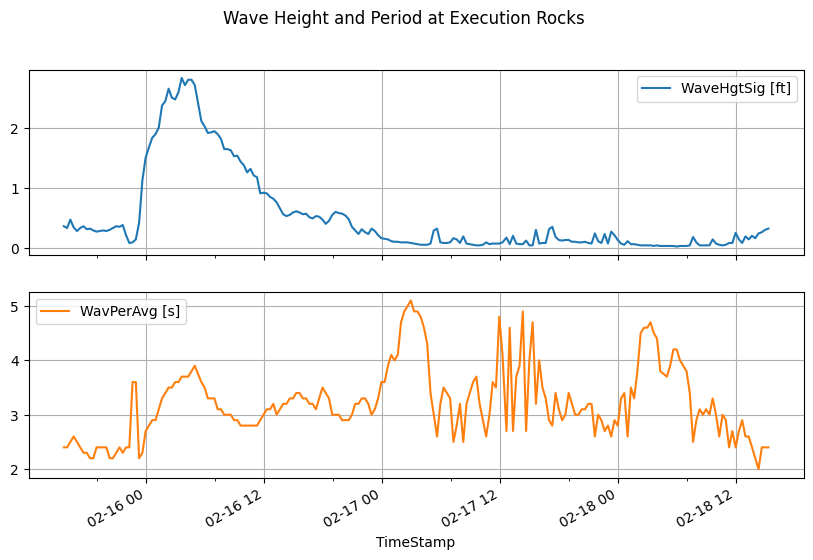

In [33]:
waveDF[['WaveHgtSig [ft]', 'WavPerAvg [s]']].plot(subplots=True, figsize=(10, 6), title="Wave Height and Period at Execution Rocks", grid=True)

array([<Axes: xlabel='TimeStamp'>, <Axes: xlabel='TimeStamp'>],
      dtype=object)

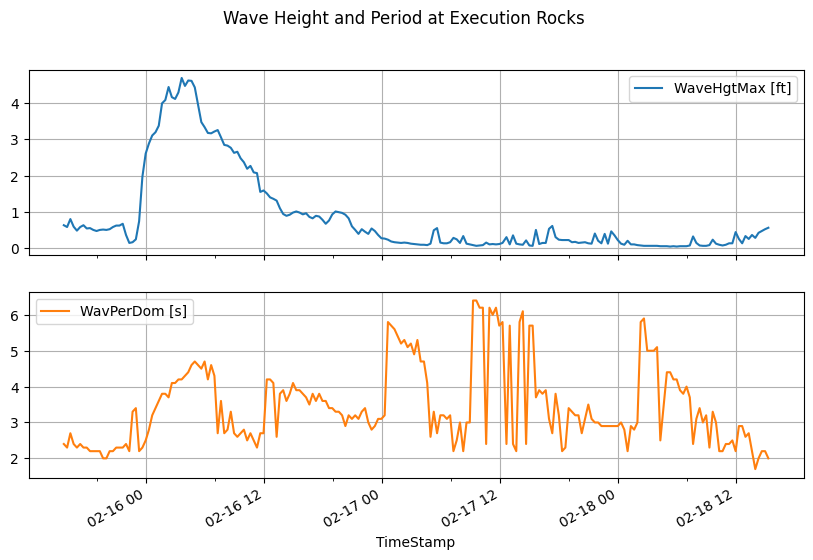

In [35]:
waveDF[['WaveHgtMax [ft]', 'WavPerDom [s]']].plot(subplots=True, figsize=(10, 6), title="Wave Height and Period at Execution Rocks", grid=True)

In [36]:
waveAvgDF = waveDF.resample('1h').mean()

TypeError: agg function failed [how->mean,dtype->object]